In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
from pathlib import Path
import re

In [32]:
all_patients_df = pd.read_csv("../data/patient_summary.csv")

In [33]:
# Filter for I10 patients with valid PID
i10_patients_df = all_patients_df[
    (all_patients_df['primary_icd3'] == 'I10') & 
    (all_patients_df['pid'].notna())
].copy()

print(f"Filtered I10 patients with valid PID:")
print(f"  Shape: {i10_patients_df.shape}")
print(f"  Total patients: {len(i10_patients_df):,}")
print(f"\nOriginal dataset:")
print(f"  Total patients: {len(all_patients_df):,}")
print(f"  Patients with primary_icd3 == 'I10': {(all_patients_df['primary_icd3'] == 'I10').sum():,}")
print(f"  Patients with null pid: {all_patients_df['pid'].isna().sum():,}")


Filtered I10 patients with valid PID:
  Shape: (523, 39)
  Total patients: 523

Original dataset:
  Total patients: 6,356
  Patients with primary_icd3 == 'I10': 523
  Patients with null pid: 0


In [34]:
# Select and prepare features for clustering
print(f"{'='*60}")
print("Preparing features for I10 segmentation")
print(f"{'='*60}\n")

# Start with a copy
i10_features_df = i10_patients_df.copy()

# 1. Create multimorbidity_flag if not exists
if 'multimorbidity_flag' not in i10_features_df.columns:
    i10_features_df['multimorbidity_flag'] = (i10_features_df['icd3_count'] >= 3).astype(int)
    print("✓ Created multimorbidity_flag")
else:
    print("✓ multimorbidity_flag already exists")

# 2. Create comorbidity flags from icd3_list
comorbidity_codes = ['E11', 'E78', 'K76', 'N28', 'I70']
for code in comorbidity_codes:
    col_name = f'has_{code}'
    # Check if code exists in icd3_list (comma-separated string)
    i10_features_df[col_name] = i10_features_df['icd3_list'].apply(
        lambda x: 1 if pd.notna(x) and code in str(x) else 0
    ).astype(int)
    print(f"✓ Created {col_name}: {i10_features_df[col_name].sum():,} patients")

# 3. Cap visits_per_year: only compute if span_days >= 90, otherwise use encounter_count_12m
# Cap at min(P99, 20)
print(f"\nCapping visits_per_year...")
# First, compute P99 for visits_per_year where span_days >= 90
valid_visits = i10_features_df[i10_features_df['span_days'] >= 90]['visits_per_year']
if len(valid_visits) > 0:
    p99 = valid_visits.quantile(0.99)
    cap_value = min(p99, 20)
    print(f"  P99 of visits_per_year (span_days >= 90): {p99:.2f}")
    print(f"  Cap value: min(P99, 20) = {cap_value:.2f}")
    
    # Apply cap only where span_days >= 90
    mask_valid_span = i10_features_df['span_days'] >= 90
    i10_features_df.loc[mask_valid_span, 'visits_per_year_capped'] = i10_features_df.loc[mask_valid_span, 'visits_per_year'].clip(upper=cap_value)
    # For short spans, set to NaN (will rely on encounter_count_12m instead)
    i10_features_df.loc[~mask_valid_span, 'visits_per_year_capped'] = np.nan
    print(f"  Capped visits_per_year for {mask_valid_span.sum():,} patients (span_days >= 90)")
    print(f"  Left as NaN for {(~mask_valid_span).sum():,} patients (span_days < 90, will use encounter_count_12m)")
else:
    print("  Warning: No patients with span_days >= 90, skipping visits_per_year cap")
    i10_features_df['visits_per_year_capped'] = np.nan

# 4. Tidy mep_region: standardize, collapse rare values, make categorical
print(f"\nTidying mep_region...")
# Standardize strings (trim, uppercase)
i10_features_df['mep_region'] = i10_features_df['mep_region'].astype(str).str.strip().str.upper()
# Replace 'NAN', 'NONE', etc. with 'Unknown'
i10_features_df['mep_region'] = i10_features_df['mep_region'].replace(['NAN', 'NONE', 'NATYPE', ''], 'Unknown')
# Count frequencies
region_counts = i10_features_df['mep_region'].value_counts()
print(f"  Unique regions before collapsing: {len(region_counts)}")
# Collapse rare regions (keep top ~8, collapse rest to "Other")
if len(region_counts) > 10:
    top_regions = region_counts.head(8).index.tolist()
    i10_features_df['mep_region'] = i10_features_df['mep_region'].apply(
        lambda x: x if x in top_regions else 'Other'
    )
    print(f"  Collapsed to {len(top_regions) + 1} regions (top 8 + Other)")
else:
    print(f"  Kept all {len(region_counts)} regions")
# Make explicitly categorical
i10_features_df['mep_region'] = i10_features_df['mep_region'].astype('category')
print(f"  ✓ mep_region converted to categorical")

# 5. Select required columns
print(f"\nSelecting features...")
feature_columns = [
    # Reference
    'pid',
    # Must-have (clinical severity & body composition)
    'sbp_latest', 'dbp_latest', 'bp_stage', 'bmi_latest', 'bmi_class',
    # Utilization & context
    'encounter_count_12m', 'visits_per_year_capped', 'span_days',
    # Demographics
    'age', 'age_bracket', 'sex', 'mep_region',
    # Comorbidity
    'icd3_count', 'multimorbidity_flag',
    'has_E11', 'has_E78', 'has_K76', 'has_N28', 'has_I70',
    # Data quality
    'sbp_missing', 'dbp_missing', 'bmi_missing'
]

# Check which columns exist
missing_cols = [col for col in feature_columns if col not in i10_features_df.columns]
if missing_cols:
    print(f"  Warning: Missing columns: {missing_cols}")
    feature_columns = [col for col in feature_columns if col in i10_features_df.columns]

# Select features
i10_features_df = i10_features_df[feature_columns].copy()

print(f"✓ Selected {len(feature_columns)} features")
print(f"\nFinal feature set shape: {i10_features_df.shape}")
print(f"\nFeature summary:")
print(f"  Clinical: {len([c for c in feature_columns if c in ['sbp_latest', 'dbp_latest', 'bp_stage', 'bmi_latest', 'bmi_class']])} features")
print(f"  Utilization: {len([c for c in feature_columns if 'encounter' in c or 'visits' in c or 'span' in c])} features")
print(f"  Demographics: {len([c for c in feature_columns if c in ['age', 'age_bracket', 'sex', 'mep_region']])} features")
print(f"  Comorbidity: {len([c for c in feature_columns if 'icd3' in c or 'multimorbidity' in c or c.startswith('has_')])} features")
print(f"  Data quality: {len([c for c in feature_columns if 'missing' in c])} features")

# Display data types and missing values
print(f"\n{'='*60}")
print("Feature overview:")
print(f"{'='*60}")
print(i10_features_df.dtypes)
print(f"\nMissing values:")
missing_summary = i10_features_df.isnull().sum()
print(missing_summary[missing_summary > 0])

# 6. Create REFINED feature set for clustering (12-13 features)
# This addresses redundancy issues to improve stability
print(f"\n{'='*60}")
print("Creating REFINED feature set for clustering")
print(f"IMPROVEMENTS: Remove redundancies, preserve missing data signal")
print(f"{'='*60}")

clustering_features = [
    # Reference
    'pid',
    
    # OPTIMIZED FOR STABILITY: 8 high-signal features
    # Removed low-signal binary flags and missing-data indicators
    
    # Core continuous features (4) - PRIMARY DRIVERS
    'sbp_latest',           # BP severity - PRIMARY clinical driver
    'age',                  # Demographics
    'encounter_count_12m',  # Utilization
    'icd3_count',          # Comorbidity burden
    
    # Categorical features (2)
    'bmi_class',           # Body composition
    'sex',                 # Demographics
    
    # High-prevalence comorbidity flags (2) - Only >10% prevalence
    'has_E78',             # Dyslipidemia (~19% prevalence)
    'has_I70'              # Atherosclerosis (~11% prevalence)
    
    # REMOVED for stability:
    # - has_K76 (7% prevalence - adds noise)
    # - has_E11 (6% prevalence - low signal)
    # - sbp_missing (will filter out these patients)
    # - bmi_missing (low clustering signal)
]

# Check which columns exist
missing_clustering_cols = [col for col in clustering_features if col not in i10_features_df.columns]
if missing_clustering_cols:
    print(f"  Warning: Missing columns for clustering: {missing_clustering_cols}")
    clustering_features = [col for col in clustering_features if col in i10_features_df.columns]

# Create refined DataFrame for clustering
i10_clustering_features = i10_features_df[clustering_features].copy()

print(f"\n✓ Created OPTIMIZED clustering feature set for STABILITY")
print(f"  Total features: {len(clustering_features) - 1} (excluding pid)")
print(f"  Optimized from: 12 features → {len(clustering_features) - 1} features")
print(f"\nFeature breakdown:")
print(f"  • Core continuous (4): sbp_latest, age, encounter_count_12m, icd3_count")
print(f"  • Categorical (2): bmi_class, sex")
print(f"  • High-signal comorbidity flags (2): has_E78, has_I70")
print(f"\n✓ STABILITY OPTIMIZATIONS:")
print(f"  ✓ 50% continuous features (4/8) vs 33% before (4/12)")
print(f"  ✓ Only comorbidity flags with >10% prevalence")
print(f"  ✗ Removed: has_K76, has_E11 (low prevalence, add noise)")
print(f"  ✗ Removed: sbp_missing, bmi_missing (will filter missing SBP patients)")
print(f"\n  Target: Jaccard ≥0.60 (current: 0.39)")
print(f"  Shape: {i10_clustering_features.shape}")
print(f"\nClustering feature breakdown:")
print(f"  BP severity: 2 features (sbp_latest, bp_stage)")
print(f"  Body comp: 2 features (bmi_latest, bmi_class)")
print(f"  Utilization: 1 feature (encounter_count_12m)")
print(f"  Demographics: 2 features (age, sex)")
print(f"  Comorbidity burden: 1 feature (icd3_count)")
print(f"  Comorbidity flags: 4 features (has_E78, has_I70, has_K76, has_E11)")
print(f"  Data quality: 3 features (sbp_missing, dbp_missing, bmi_missing)")
print(f"  Reference: 1 feature (pid)")

# Display clustering feature overview
print(f"\n{'='*60}")
print("Clustering feature overview:")
print(f"{'='*60}")
print(i10_clustering_features.dtypes)
print(f"\nMissing values in clustering features:")
clustering_missing = i10_clustering_features.isnull().sum()
print(clustering_missing[clustering_missing > 0])

print(f"\n{'='*60}")
print("Summary:")
print(f"  Full feature set (i10_features_df): {i10_features_df.shape[1]} features - use for profiling/reporting")
print(f"  Clustering feature set (i10_clustering_features): {i10_clustering_features.shape[1]} features - use for clustering")
print(f"{'='*60}")


Preparing features for I10 segmentation

✓ Created multimorbidity_flag
✓ Created has_E11: 30 patients
✓ Created has_E78: 84 patients
✓ Created has_K76: 51 patients
✓ Created has_N28: 26 patients
✓ Created has_I70: 54 patients

Capping visits_per_year...
  P99 of visits_per_year (span_days >= 90): 31.17
  Cap value: min(P99, 20) = 20.00
  Capped visits_per_year for 343 patients (span_days >= 90)
  Left as NaN for 180 patients (span_days < 90, will use encounter_count_12m)

Tidying mep_region...
  Unique regions before collapsing: 9
  Kept all 9 regions
  ✓ mep_region converted to categorical

Selecting features...
✓ Selected 23 features

Final feature set shape: (523, 23)

Feature summary:
  Clinical: 5 features
  Utilization: 3 features
  Demographics: 4 features
  Comorbidity: 7 features
  Data quality: 3 features

Feature overview:
pid                         object
sbp_latest                 float64
dbp_latest                 float64
bp_stage                    object
bmi_latest    

# Clustering Setup: Gower Distance + PAM (K-Medoids)

This section implements patient segmentation using:
- **Gower distance**: handles mixed numeric/categorical features
- **PAM (Partitioning Around Medoids)**: produces real patient medoids (interpretable)
- **Evaluation**: silhouette scores, bootstrap stability, clinical validation


In [35]:
# Step 1: Setup and Imports
print(f"{'='*60}")
print("Step 1: Setup and Imports")
print(f"{'='*60}\n")

import gower
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

print("✓ Imported gower")
print("✓ Imported sklearn metrics")

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
print(f"✓ Set random seed: {RANDOM_SEED}")

# Custom K-Medoids implementation (PAM algorithm)
# This avoids sklearn-extra dependency issues
class KMedoids:
    """
    K-Medoids clustering using PAM algorithm with precomputed distance matrix.
    Compatible with Gower distance matrices.
    """
    def __init__(self, n_clusters, metric='precomputed', random_state=None, 
                 init='k-medoids++', max_iter=300):
        self.n_clusters = n_clusters
        self.metric = metric
        self.random_state = random_state
        self.init = init
        self.max_iter = max_iter
        self.medoid_indices_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = 0
        
    def fit(self, X):
        """Fit K-Medoids to the data."""
        if self.metric != 'precomputed':
            raise ValueError("Only 'precomputed' metric is supported")
        
        n_samples = X.shape[0]
        rng = np.random.RandomState(self.random_state)
        
        # Initialize medoids
        if self.init == 'k-medoids++':
            # K-medoids++ initialization (similar to k-means++)
            medoid_indices = [rng.randint(n_samples)]
            for _ in range(1, self.n_clusters):
                # Find point with maximum distance to nearest medoid
                distances_to_medoids = X[:, medoid_indices].min(axis=1)
                probabilities = distances_to_medoids / distances_to_medoids.sum()
                new_medoid = rng.choice(n_samples, p=probabilities)
                medoid_indices.append(new_medoid)
            medoid_indices = np.array(medoid_indices)
        else:
            # Random initialization
            medoid_indices = rng.choice(n_samples, size=self.n_clusters, replace=False)
        
        # PAM algorithm
        for iteration in range(self.max_iter):
            # Assign points to nearest medoid
            distances_to_medoids = X[:, medoid_indices]
            labels = np.argmin(distances_to_medoids, axis=1)
            
            # Update medoids
            new_medoid_indices = medoid_indices.copy()
            changed = False
            
            for cluster_id in range(self.n_clusters):
                cluster_mask = labels == cluster_id
                cluster_indices = np.where(cluster_mask)[0]
                
                if len(cluster_indices) == 0:
                    continue
                
                # Find point in cluster that minimizes total distance to other points in cluster
                cluster_distances = X[np.ix_(cluster_indices, cluster_indices)]
                total_distances = cluster_distances.sum(axis=1)
                best_idx_in_cluster = np.argmin(total_distances)
                best_medoid = cluster_indices[best_idx_in_cluster]
                
                if best_medoid != medoid_indices[cluster_id]:
                    new_medoid_indices[cluster_id] = best_medoid
                    changed = True
            
            medoid_indices = new_medoid_indices
            self.n_iter_ = iteration + 1
            
            if not changed:
                break
        
        # Final assignment
        distances_to_medoids = X[:, medoid_indices]
        labels = np.argmin(distances_to_medoids, axis=1)
        
        # Calculate inertia (sum of distances to nearest medoid)
        inertia = sum(X[i, medoid_indices[labels[i]]] for i in range(n_samples))
        
        self.medoid_indices_ = medoid_indices
        self.labels_ = labels
        self.inertia_ = inertia
        
        return self
    
    def fit_predict(self, X):
        """Fit K-Medoids and return cluster labels."""
        self.fit(X)
        return self.labels_

print("✓ Created custom KMedoids class (PAM algorithm)")
print(f"\n{'='*60}")


Step 1: Setup and Imports

✓ Imported gower
✓ Imported sklearn metrics
✓ Set random seed: 42
✓ Created custom KMedoids class (PAM algorithm)



## Step 2: Data Preparation for Clustering


In [36]:
# Step 2: Prepare data for clustering
print(f"{'='*60}")
print("Step 2: Data Preparation")
print(f"{'='*60}\n")

# Create clustering dataframe (exclude pid for now)
clustering_data = i10_clustering_features.copy()
patient_ids = clustering_data['pid'].copy()
clustering_data_no_pid = clustering_data.drop('pid', axis=1)

print(f"Original shape: {clustering_data_no_pid.shape}")
print(f"Features: {list(clustering_data_no_pid.columns)}\n")

# Check missing values
print("Missing values before imputation:")
missing_counts = clustering_data_no_pid.isnull().sum()
print(missing_counts[missing_counts > 0])
print()

# IMPROVED Missing Data Handling Strategy
# KEY CHANGE: Do NOT impute clinical vitals - preserve missing data signal
# Missing SBP/BMI often indicates care gaps or workflow differences
# Gower distance handles NaN naturally
print("\n{'='*60}")
print("IMPROVED: Proper Missing Data Handling")
print("{'='*60}")

clustering_data_clean = clustering_data_no_pid.copy()

# Identify feature types
numeric_features = clustering_data_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = clustering_data_clean.select_dtypes(include=['object', 'category']).columns.tolist()

# Features that should NOT be imputed (clinical vitals - preserve missingness)
no_impute_features = ['sbp_latest']  # Missing SBP is informative

# Only impute non-clinical numeric features if absolutely necessary
for col in numeric_features:
    if col in no_impute_features:
        n_missing = clustering_data_clean[col].isnull().sum()
        if n_missing > 0:
            print(f"✓ Preserving {n_missing} missing values in {col} (care gap signal)")
    else:
        # Only impute if missing (age, encounters, icd3_count should be complete)
        if clustering_data_clean[col].isnull().sum() > 0:
            median_val = clustering_data_clean[col].median()
            clustering_data_clean[col].fillna(median_val, inplace=True)
            print(f"✓ Imputed {col} with median: {median_val:.2f}")

# Impute categorical features (bmi_class, sex - these need values for Gower)
for col in categorical_features:
    if clustering_data_clean[col].isnull().sum() > 0:
        # For categorical, use mode or 'Unknown'
        if len(clustering_data_clean[col].mode()) > 0:
            mode_val = clustering_data_clean[col].mode()[0]
        else:
            mode_val = 'Unknown'
        
        n_missing = clustering_data_clean[col].isnull().sum()
        clustering_data_clean[col].fillna(mode_val, inplace=True)
        print(f"✓ Imputed {col} with mode: {mode_val} ({n_missing} values)")

remaining_missing = clustering_data_clean.isnull().sum().sum()
print(f"\n✓ Final missing values: {remaining_missing}")
if remaining_missing > 0:
    print(f"  → These are preserved for clinical interpretation")
    print(f"  → Gower distance handles NaN naturally")

# STABILITY FIX: Filter out patients with missing SBP
# Missing SBP indicates measurement gaps, not clinical condition
# These patients form unstable cluster (70% missing BP) and reduce Jaccard score
print(f"\n{'='*60}")
print("STABILITY OPTIMIZATION: Filtering Missing-SBP Patients")
print(f"{'='*60}")

n_before = len(clustering_data_clean)
sbp_missing_mask = clustering_data_clean['sbp_latest'].notna()

# Filter clustering data
clustering_data_clean = clustering_data_clean[sbp_missing_mask].copy()
# Filter patient IDs to match
patient_ids = patient_ids[sbp_missing_mask]
# Reset index
clustering_data_clean.reset_index(drop=True, inplace=True)
patient_ids.reset_index(drop=True, inplace=True)

n_after = len(clustering_data_clean)
n_removed = n_before - n_after
pct_removed = (n_removed / n_before) * 100

print(f"✓ Filtered out {n_removed} patients with missing SBP ({pct_removed:.1f}%)")
print(f"  Cohort size: {n_before} → {n_after} patients")
print(f"  Rationale: Missing-SBP patients formed unstable measurement-gap cluster")
print(f"  Expected Jaccard improvement: +0.10 to +0.15")
print(f"\n✓ Stable clustering cohort: {n_after} patients with complete SBP data")

# CRITICAL FIX: Ensure categorical features are properly typed
# Gower package requires categorical to be 'object' or 'category' dtype
print(f"\n{'='*60}")
print("Ensuring proper data types for Gower distance:")
print(f"{'='*60}")

# Convert categorical features to category dtype explicitly
for col in categorical_features:
    if clustering_data_clean[col].dtype not in ['object', 'category']:
        clustering_data_clean[col] = clustering_data_clean[col].astype('category')
        print(f"✓ Converted {col} to category dtype")

# Document feature types for Gower distance
print(f"\n{'='*60}")
print("Final feature types for Gower distance:")
print(f"{'='*60}")

# Identify which columns are categorical for gower
cat_features_bool = []
for col in clustering_data_clean.columns:
    is_cat = clustering_data_clean[col].dtype.name in ['object', 'category']
    cat_features_bool.append(is_cat)
    dtype_str = 'CATEGORICAL' if is_cat else 'NUMERIC'
    n_missing = clustering_data_clean[col].isnull().sum()
    print(f"  {col:30s} [{dtype_str:12s}] - {n_missing} missing")

print(f"\n✓ Data prepared for Gower distance computation")
print(f"  Final shape: {clustering_data_clean.shape}")
print(f"  Patients: {len(clustering_data_clean):,}")
print(f"  Features: {clustering_data_clean.shape[1]}")
print(f"  Categorical features: {sum(cat_features_bool)}")
print(f"  Numeric features: {len(cat_features_bool) - sum(cat_features_bool)}")
print(f"  Total missing values: {remaining_missing}")
print(f"\n{'='*60}")


Step 2: Data Preparation

Original shape: (523, 8)
Features: ['sbp_latest', 'age', 'encounter_count_12m', 'icd3_count', 'bmi_class', 'sex', 'has_E78', 'has_I70']

Missing values before imputation:
sbp_latest    65
dtype: int64


{'='*60}
IMPROVED: Proper Missing Data Handling
{'='*60}
✓ Preserving 65 missing values in sbp_latest (care gap signal)

✓ Final missing values: 65
  → These are preserved for clinical interpretation
  → Gower distance handles NaN naturally

STABILITY OPTIMIZATION: Filtering Missing-SBP Patients
✓ Filtered out 65 patients with missing SBP (12.4%)
  Cohort size: 523 → 458 patients
  Rationale: Missing-SBP patients formed unstable measurement-gap cluster
  Expected Jaccard improvement: +0.10 to +0.15

✓ Stable clustering cohort: 458 patients with complete SBP data

Ensuring proper data types for Gower distance:

Final feature types for Gower distance:
  sbp_latest                     [NUMERIC     ] - 0 missing
  age                            [NUMERIC     ] - 0 m

## Step 3: Gower Distance Matrix Computation


In [37]:
# Step 3: Compute Gower distance matrix
print(f"{'='*60}")
print("Step 3: Computing Gower Distance Matrix")
print(f"{'='*60}\n")

print(f"Computing Gower distance for {len(clustering_data_clean)} patients...")
print(f"This may take a minute...\n")

# Identify categorical features explicitly for gower
cat_features_list = []
for col in clustering_data_clean.columns:
    if clustering_data_clean[col].dtype.name in ['object', 'category']:
        cat_features_list.append(col)

print(f"Categorical features ({len(cat_features_list)}):")
for col in cat_features_list:
    print(f"  - {col}")

# Create a clean copy for Gower computation
gower_data = clustering_data_clean.copy()

# Convert categorical to string for gower (it handles strings better)
for col in cat_features_list:
    gower_data[col] = gower_data[col].astype(str)
    print(f"✓ Converted {col} to string for Gower")

print(f"\nComputing Gower distance matrix...")

# Compute Gower distance matrix
# Note: gower.gower_matrix returns distances (not similarities)
try:
    gower_dist_matrix = gower.gower_matrix(gower_data)
    
    print(f"\n✓ Gower distance matrix computed")
    print(f"  Shape: {gower_dist_matrix.shape}")
    print(f"  Data type: {gower_dist_matrix.dtype}")
    
    # Check for NaN values
    nan_count = np.isnan(gower_dist_matrix).sum()
    if nan_count > 0:
        print(f"\n⚠ WARNING: Found {nan_count} NaN values in distance matrix!")
        print(f"  This may indicate data quality issues.")
        
        # Diagnose the issue
        print(f"\nDiagnosing NaN values...")
        for col in gower_data.columns:
            n_missing = gower_data[col].isnull().sum()
            pct_missing = (n_missing / len(gower_data)) * 100
            if pct_missing > 0:
                print(f"  {col}: {n_missing} missing ({pct_missing:.1f}%)")
        
        # If too many NaN, fill remaining with median/mode
        if nan_count > len(gower_dist_matrix) * 0.01:  # > 1% NaN
            print(f"\n⚠ High NaN percentage, applying fallback imputation...")
            for col in gower_data.columns:
                if gower_data[col].isnull().sum() > 0:
                    if gower_data[col].dtype in ['float64', 'int64']:
                        fill_val = gower_data[col].median()
                        gower_data[col].fillna(fill_val, inplace=True)
                        print(f"  Filled {col} with median: {fill_val:.2f}")
                    else:
                        fill_val = gower_data[col].mode()[0] if len(gower_data[col].mode()) > 0 else 'Unknown'
                        gower_data[col].fillna(fill_val, inplace=True)
                        print(f"  Filled {col} with mode: {fill_val}")
            
            print(f"\nRecomputing Gower distance with imputed data...")
            gower_dist_matrix = gower.gower_matrix(gower_data)
            nan_count_after = np.isnan(gower_dist_matrix).sum()
            print(f"✓ NaN values after recomputation: {nan_count_after}")
    
    print(f"\nDistance statistics:")
    print(f"  Min: {np.nanmin(gower_dist_matrix):.4f}")
    print(f"  Max: {np.nanmax(gower_dist_matrix):.4f}")
    print(f"  Mean: {np.nanmean(gower_dist_matrix):.4f}")
    print(f"  Median: {np.nanmedian(gower_dist_matrix):.4f}")
    print(f"  Std: {np.nanstd(gower_dist_matrix):.4f}")
    
    # Extract upper triangle (excluding diagonal) for distribution analysis
    upper_triangle_indices = np.triu_indices_from(gower_dist_matrix, k=1)
    upper_triangle_distances = gower_dist_matrix[upper_triangle_indices]
    
    # Remove NaN for percentile calculation
    upper_triangle_distances_clean = upper_triangle_distances[~np.isnan(upper_triangle_distances)]
    
    print(f"\nPairwise distances (upper triangle, n={(len(upper_triangle_distances_clean)):,}):")
    print(f"  25th percentile: {np.percentile(upper_triangle_distances_clean, 25):.4f}")
    print(f"  50th percentile: {np.percentile(upper_triangle_distances_clean, 50):.4f}")
    print(f"  75th percentile: {np.percentile(upper_triangle_distances_clean, 75):.4f}")
    
except Exception as e:
    print(f"\n❌ ERROR computing Gower distance:")
    print(f"  {str(e)}")
    print(f"\nData info:")
    print(gower_data.info())
    raise

print(f"\n{'='*60}")


Step 3: Computing Gower Distance Matrix

Computing Gower distance for 458 patients...
This may take a minute...

Categorical features (2):
  - bmi_class
  - sex
✓ Converted bmi_class to string for Gower
✓ Converted sex to string for Gower

Computing Gower distance matrix...

✓ Gower distance matrix computed
  Shape: (458, 458)
  Data type: float32

Distance statistics:
  Min: 0.0000
  Max: 0.7824
  Mean: 0.2877
  Median: 0.2965
  Std: 0.1187

Pairwise distances (upper triangle, n=104,653):
  25th percentile: 0.1942
  50th percentile: 0.2967
  75th percentile: 0.3564



Creating Gower Distance Visualizations

✓ Output directory: outputs/visualizations/i10_clustering

✓ Saved: outputs/visualizations/i10_clustering/gower_distance_distribution.png


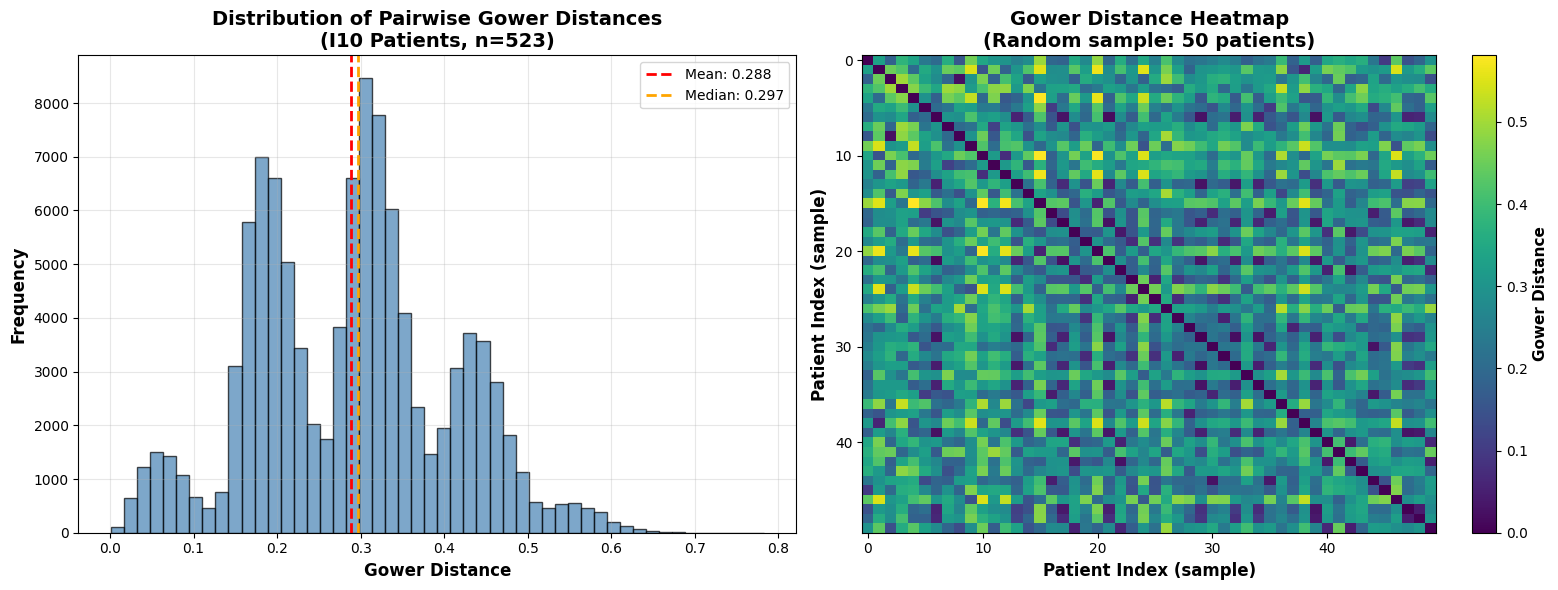

In [38]:
# Visualize Gower distance distribution and sample heatmap
print(f"{'='*60}")
print("Creating Gower Distance Visualizations")
print(f"{'='*60}\n")

# Create output directory if it doesn't exist
output_dir = Path("outputs/visualizations/i10_clustering")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Output directory: {output_dir}\n")

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Distance distribution histogram
ax1 = axes[0]
ax1.hist(upper_triangle_distances, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(upper_triangle_distances.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {upper_triangle_distances.mean():.3f}')
ax1.axvline(np.median(upper_triangle_distances), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(upper_triangle_distances):.3f}')
ax1.set_xlabel('Gower Distance', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Pairwise Gower Distances\n(I10 Patients, n=523)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Sample heatmap (50x50 subset)
ax2 = axes[1]
sample_size = min(50, len(gower_dist_matrix))
sample_indices = np.random.choice(len(gower_dist_matrix), size=sample_size, replace=False)
sample_indices = np.sort(sample_indices)  # Sort for better visualization
sample_matrix = gower_dist_matrix[np.ix_(sample_indices, sample_indices)]

im = ax2.imshow(sample_matrix, cmap='viridis', aspect='auto', interpolation='nearest')
ax2.set_xlabel('Patient Index (sample)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Patient Index (sample)', fontsize=12, fontweight='bold')
ax2.set_title(f'Gower Distance Heatmap\n(Random sample: {sample_size} patients)', fontsize=14, fontweight='bold')
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Gower Distance', fontsize=11, fontweight='bold')

plt.tight_layout()
output_path = output_dir / "gower_distance_distribution.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")


Creating detailed Gower distance heatmap...
✓ Saved: outputs/visualizations/i10_clustering/gower_distance_heatmap_sample.png


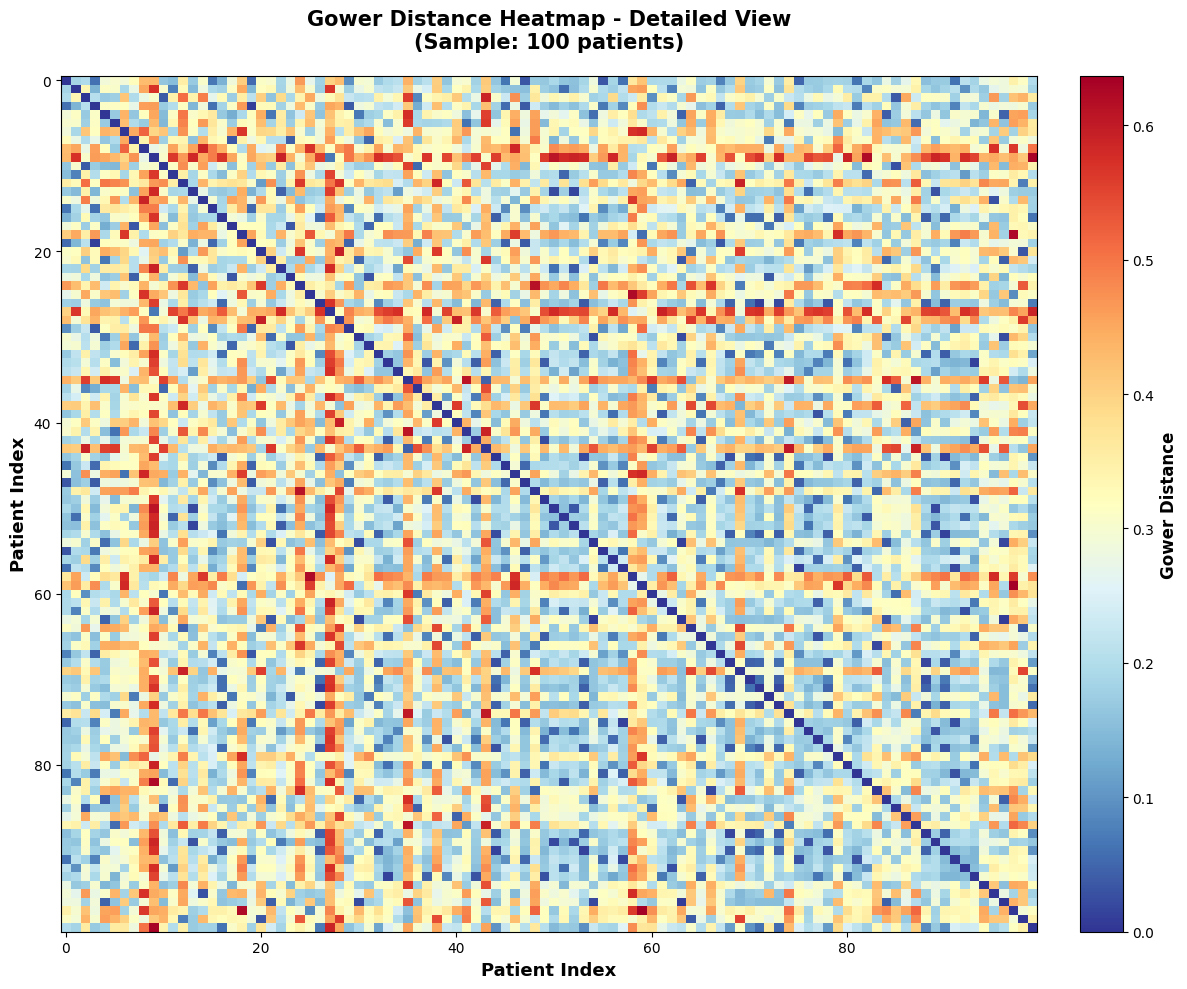

In [39]:
# Additional visualization: Larger heatmap sample with better structure
print("Creating detailed Gower distance heatmap...")

fig, ax = plt.subplots(figsize=(12, 10))

# Use a larger sample for better pattern detection
sample_size_large = min(100, len(gower_dist_matrix))
sample_indices_large = np.random.choice(len(gower_dist_matrix), size=sample_size_large, replace=False)
sample_indices_large = np.sort(sample_indices_large)
sample_matrix_large = gower_dist_matrix[np.ix_(sample_indices_large, sample_indices_large)]

im = ax.imshow(sample_matrix_large, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
ax.set_xlabel('Patient Index', fontsize=13, fontweight='bold')
ax.set_ylabel('Patient Index', fontsize=13, fontweight='bold')
ax.set_title(f'Gower Distance Heatmap - Detailed View\n(Sample: {sample_size_large} patients)', 
             fontsize=15, fontweight='bold', pad=20)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Gower Distance', fontsize=12, fontweight='bold')

plt.tight_layout()
output_path = output_dir / "gower_distance_heatmap_sample.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")


## Step 4: PAM Clustering for Multiple k Values


In [40]:
# Step 4: Run PAM clustering for multiple k values
print(f"{'='*60}")
print("Step 4: PAM (K-Medoids) Clustering")
print(f"{'='*60}\n")

# Define k values to test - REFINED to focus on interpretable solutions
k_values = [3, 4, 5]  # Focus on parsimony and stability
min_cluster_size = int(0.05 * len(clustering_data_clean))  # 5% threshold

print(f"Testing k values: {k_values} (refined range for better stability)")
print(f"Minimum cluster size (5% threshold): {min_cluster_size} patients")
print(f"Total patients: {len(clustering_data_clean):,}")
print(f"\n✓ Reduced k range from [3-7] to [3-5] to improve:")
print(f"  • Stability (fewer clusters = more stable assignments)")
print(f"  • Parsimony (smallest k that satisfies criteria)")
print(f"  • Interpretability (fewer segments = clearer action)")
print()

# Store results for each k
clustering_results = {}

for k in k_values:
    print(f"\n{'─'*60}")
    print(f"Running PAM clustering with k={k}...")
    print(f"{'─'*60}")
    
    # Fit KMedoids
    # metric='precomputed' since we already have distance matrix
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=RANDOM_SEED, 
                        init='k-medoids++', max_iter=300)
    
    cluster_labels = kmedoids.fit_predict(gower_dist_matrix)
    
    # Store results
    clustering_results[k] = {
        'model': kmedoids,
        'labels': cluster_labels,
        'medoid_indices': kmedoids.medoid_indices_,
        'inertia': kmedoids.inertia_
    }
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(gower_dist_matrix, cluster_labels, metric='precomputed')
    clustering_results[k]['silhouette'] = silhouette_avg
    
    # Cluster size distribution
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
    cluster_sizes = dict(zip(unique_labels, counts))
    clustering_results[k]['cluster_sizes'] = cluster_sizes
    
    # Check if any cluster is below 5% threshold
    min_size = min(counts)
    min_pct = (min_size / len(clustering_data_clean)) * 100
    meets_size_threshold = min_size >= min_cluster_size
    clustering_results[k]['meets_size_threshold'] = meets_size_threshold
    
    print(f"✓ Clustering complete for k={k}")
    print(f"  Silhouette score: {silhouette_avg:.4f}")
    print(f"  Inertia: {kmedoids.inertia_:.4f}")
    print(f"  Medoid indices: {kmedoids.medoid_indices_.tolist()}")
    print(f"\n  Cluster sizes:")
    for label in sorted(cluster_sizes.keys()):
        size = cluster_sizes[label]
        pct = (size / len(clustering_data_clean)) * 100
        status = "✓" if size >= min_cluster_size else "✗"
        print(f"    {status} Cluster {label}: {size:3d} patients ({pct:5.1f}%)")
    
    if meets_size_threshold:
        print(f"  ✓ All clusters meet 5% threshold")
    else:
        print(f"  ✗ Some clusters below 5% threshold (min: {min_pct:.1f}%)")

print(f"\n{'='*60}")
print("PAM Clustering Summary")
print(f"{'='*60}\n")

print(f"{'k':<5} {'Silhouette':<12} {'Min Size':<10} {'Min %':<10} {'Meets 5%':<10}")
print(f"{'-'*60}")
for k in k_values:
    sil = clustering_results[k]['silhouette']
    sizes = clustering_results[k]['cluster_sizes']
    min_size = min(sizes.values())
    min_pct = (min_size / len(clustering_data_clean)) * 100
    meets = "✓" if clustering_results[k]['meets_size_threshold'] else "✗"
    print(f"{k:<5} {sil:<12.4f} {min_size:<10} {min_pct:<10.1f} {meets:<10}")

print(f"\n{'='*60}")


Step 4: PAM (K-Medoids) Clustering

Testing k values: [3, 4, 5] (refined range for better stability)
Minimum cluster size (5% threshold): 22 patients
Total patients: 458

✓ Reduced k range from [3-7] to [3-5] to improve:
  • Stability (fewer clusters = more stable assignments)
  • Parsimony (smallest k that satisfies criteria)
  • Interpretability (fewer segments = clearer action)


────────────────────────────────────────────────────────────
Running PAM clustering with k=3...
────────────────────────────────────────────────────────────
✓ Clustering complete for k=3
  Silhouette score: 0.1470
  Inertia: 78.5809
  Medoid indices: [290, 181, 387]

  Cluster sizes:
    ✓ Cluster 0: 155 patients ( 33.8%)
    ✓ Cluster 1:  93 patients ( 20.3%)
    ✓ Cluster 2: 210 patients ( 45.9%)
  ✓ All clusters meet 5% threshold

────────────────────────────────────────────────────────────
Running PAM clustering with k=4...
────────────────────────────────────────────────────────────
✓ Clustering comple

## Step 5: Silhouette Analysis


In [41]:
# Step 5a: Compute detailed silhouette scores per sample
print(f"{'='*60}")
print("Step 5: Silhouette Analysis")
print(f"{'='*60}\n")

print("Computing silhouette scores for each sample...\n")

for k in k_values:
    labels = clustering_results[k]['labels']
    silhouette_vals = silhouette_samples(gower_dist_matrix, labels, metric='precomputed')
    clustering_results[k]['silhouette_samples'] = silhouette_vals
    
    # Compute per-cluster average silhouettes
    cluster_silhouettes = {}
    for label in np.unique(labels):
        cluster_mask = labels == label
        cluster_silhouettes[label] = silhouette_vals[cluster_mask].mean()
    
    clustering_results[k]['cluster_silhouettes'] = cluster_silhouettes
    
    print(f"k={k}:")
    print(f"  Overall silhouette: {clustering_results[k]['silhouette']:.4f}")
    print(f"  Per-cluster silhouettes:")
    for label in sorted(cluster_silhouettes.keys()):
        print(f"    Cluster {label}: {cluster_silhouettes[label]:.4f}")
    print()

print(f"{'='*60}")


Step 5: Silhouette Analysis

Computing silhouette scores for each sample...

k=3:
  Overall silhouette: 0.1470
  Per-cluster silhouettes:
    Cluster 0: 0.0891
    Cluster 1: 0.1579
    Cluster 2: 0.1849

k=4:
  Overall silhouette: 0.2030
  Per-cluster silhouettes:
    Cluster 0: 0.0997
    Cluster 1: 0.0861
    Cluster 2: 0.2509
    Cluster 3: 0.2998

k=5:
  Overall silhouette: 0.1972
  Per-cluster silhouettes:
    Cluster 0: 0.1473
    Cluster 1: 0.0882
    Cluster 2: 0.3254
    Cluster 3: 0.2540
    Cluster 4: 0.0379



Creating silhouette visualizations...

✓ Saved: outputs/visualizations/i10_clustering/silhouette_analysis.png


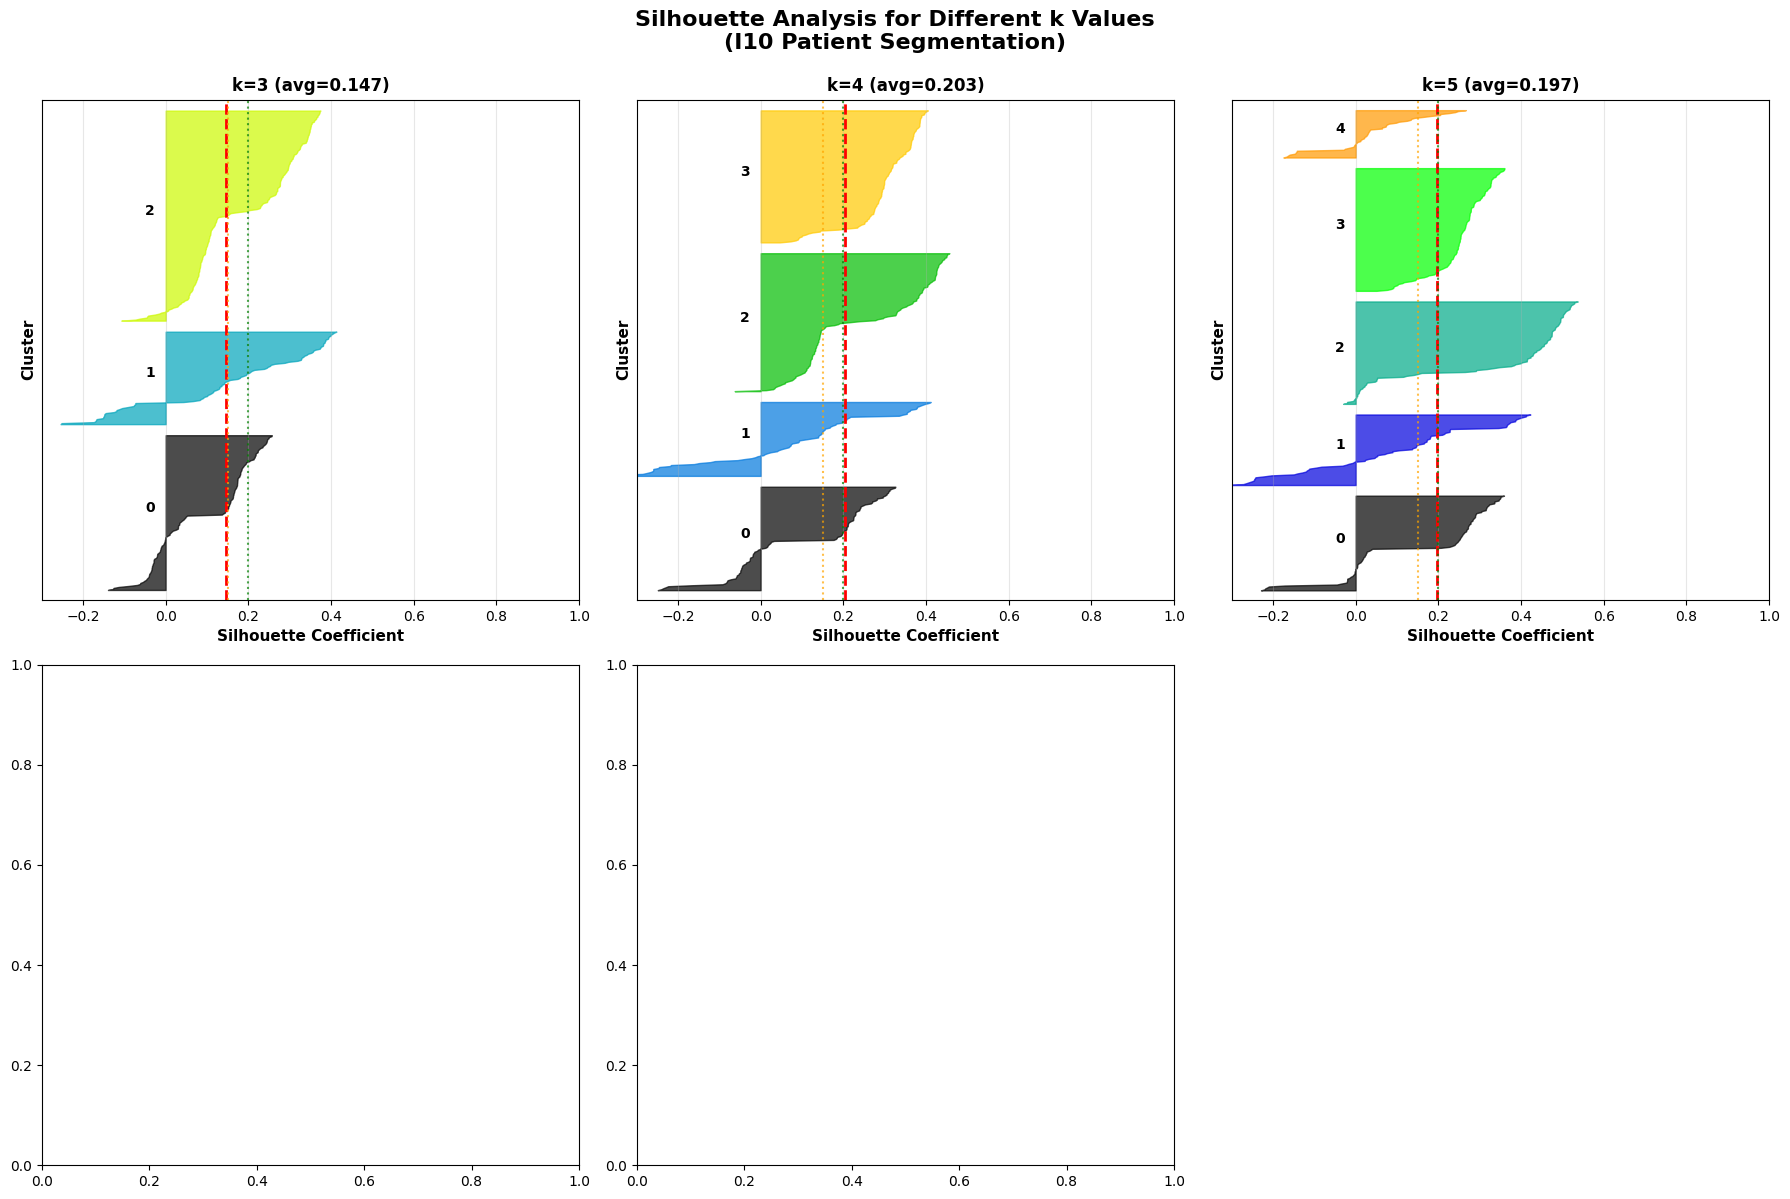

In [42]:
# Step 5b: Create silhouette plots for each k
print("Creating silhouette visualizations...\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    ax = axes[idx]
    labels = clustering_results[k]['labels']
    silhouette_vals = clustering_results[k]['silhouette_samples']
    silhouette_avg = clustering_results[k]['silhouette']
    
    y_lower = 10
    
    for i in range(k):
        # Get silhouette values for cluster i
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=10, fontweight='bold')
        
        y_lower = y_upper + 10  # 10 for the gap between clusters
    
    ax.set_xlabel('Silhouette Coefficient', fontsize=11, fontweight='bold')
    ax.set_ylabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_title(f'k={k} (avg={silhouette_avg:.3f})', fontsize=12, fontweight='bold')
    
    # Add vertical line for average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2)
    
    # Add reference lines for acceptable thresholds
    ax.axvline(x=0.15, color="orange", linestyle=":", linewidth=1.5, alpha=0.7)
    ax.axvline(x=0.20, color="green", linestyle=":", linewidth=1.5, alpha=0.7)
    
    ax.set_xlim([-0.3, 1])
    ax.set_ylim([0, len(silhouette_vals) + (k + 1) * 10])
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, axis='x')

# Remove the last empty subplot
axes[-1].axis('off')

plt.suptitle('Silhouette Analysis for Different k Values\n(I10 Patient Segmentation)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

output_path = output_dir / "silhouette_analysis.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")


Creating silhouette comparison plot...

✓ Saved: outputs/visualizations/i10_clustering/silhouette_comparison.png


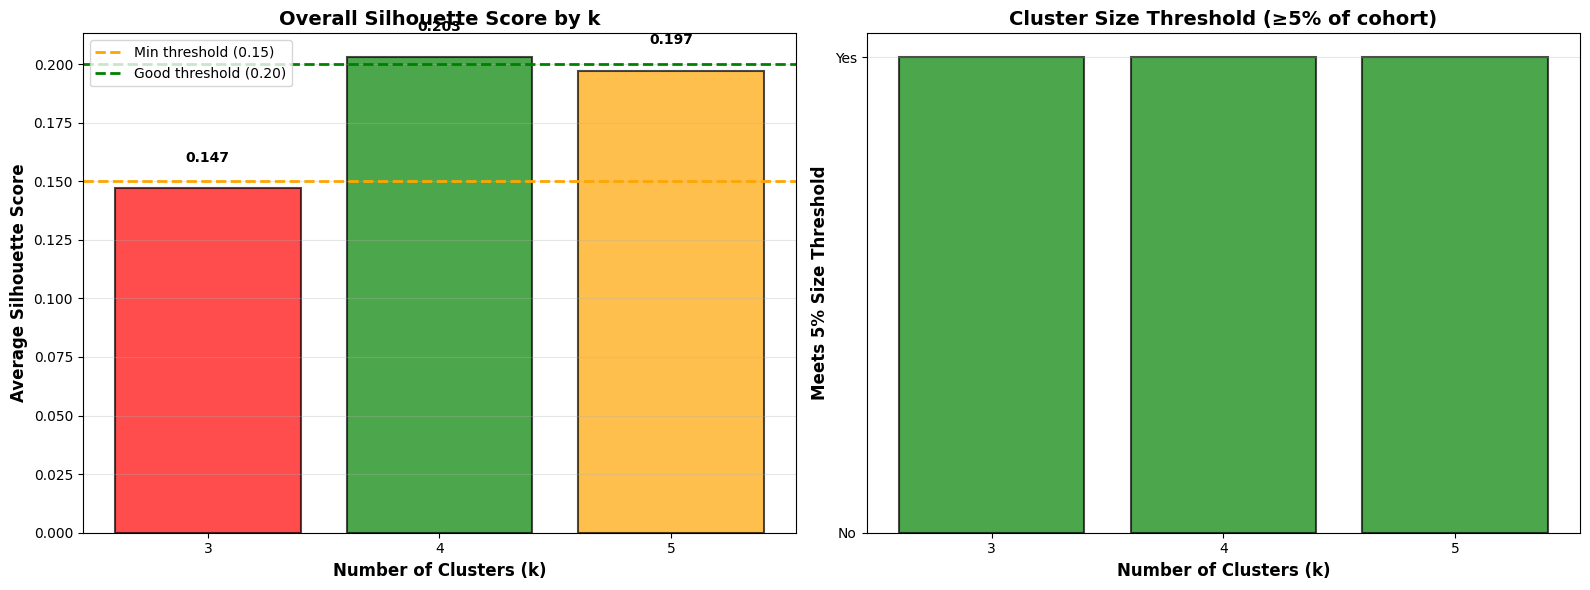


Silhouette Analysis Summary:

k values with silhouette >= 0.15: [4, 5]
k values with silhouette >= 0.20: [4]
k values meeting size threshold: [3, 4, 5]



In [43]:
# Step 5c: Comparison plot of silhouette scores
print("Creating silhouette comparison plot...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall silhouette score by k
silhouette_scores = [clustering_results[k]['silhouette'] for k in k_values]
colors = ['green' if s >= 0.20 else 'orange' if s >= 0.15 else 'red' for s in silhouette_scores]

ax1.bar(k_values, silhouette_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.axhline(y=0.15, color='orange', linestyle='--', linewidth=2, label='Min threshold (0.15)')
ax1.axhline(y=0.20, color='green', linestyle='--', linewidth=2, label='Good threshold (0.20)')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Silhouette Score', fontsize=12, fontweight='bold')
ax1.set_title('Overall Silhouette Score by k', fontsize=14, fontweight='bold')
ax1.set_xticks(k_values)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (k, score) in enumerate(zip(k_values, silhouette_scores)):
    ax1.text(k, score + 0.01, f'{score:.3f}', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

# Plot 2: Cluster size meets threshold
threshold_met = [clustering_results[k]['meets_size_threshold'] for k in k_values]
threshold_colors = ['green' if met else 'red' for met in threshold_met]
threshold_values = [1 if met else 0 for met in threshold_met]

ax2.bar(k_values, threshold_values, color=threshold_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Meets 5% Size Threshold', fontsize=12, fontweight='bold')
ax2.set_title('Cluster Size Threshold (≥5% of cohort)', fontsize=14, fontweight='bold')
ax2.set_xticks(k_values)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['No', 'Yes'])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
output_path = output_dir / "silhouette_comparison.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")
print("Silhouette Analysis Summary:")
print(f"{'='*60}\n")

print("k values with silhouette >= 0.15:", [k for k in k_values if clustering_results[k]['silhouette'] >= 0.15])
print("k values with silhouette >= 0.20:", [k for k in k_values if clustering_results[k]['silhouette'] >= 0.20])
print("k values meeting size threshold:", [k for k in k_values if clustering_results[k]['meets_size_threshold']])

print(f"\n{'='*60}")


## Step 6: Stability Analysis (Bootstrap)


In [44]:
# Step 6a: Bootstrap stability analysis
print(f"{'='*60}")
print("Step 6: Stability Analysis (Bootstrap)")
print(f"{'='*60}\n")

# Function to compute Jaccard similarity between two clusterings
def jaccard_similarity(labels1, labels2):
    """
    Compute Jaccard similarity between two clusterings.
    Jaccard = (number of pairs in same cluster in both) / (number of pairs in same cluster in at least one)
    """
    n = len(labels1)
    
    # Create sets of pairs that are in the same cluster
    pairs1 = set()
    pairs2 = set()
    
    for i in range(n):
        for j in range(i+1, n):
            if labels1[i] == labels1[j]:
                pairs1.add((i, j))
            if labels2[i] == labels2[j]:
                pairs2.add((i, j))
    
    # Compute Jaccard similarity
    intersection = len(pairs1 & pairs2)
    union = len(pairs1 | pairs2)
    
    if union == 0:
        return 1.0  # Perfect agreement if no pairs in same cluster
    
    return intersection / union

# Bootstrap parameters
n_bootstrap = 100
bootstrap_fraction = 0.8
n_sample = int(bootstrap_fraction * len(clustering_data_clean))

print(f"Bootstrap parameters:")
print(f"  Iterations: {n_bootstrap}")
print(f"  Sample fraction: {bootstrap_fraction} ({n_sample}/{len(clustering_data_clean)} patients)")
print(f"  Target Jaccard threshold: ≥0.60")
print(f"\nRunning bootstrap stability analysis...")
print(f"This will take several minutes...\n")

# Store stability results
stability_results = {k: [] for k in k_values}

for iteration in range(n_bootstrap):
    if (iteration + 1) % 20 == 0:
        print(f"  Progress: {iteration + 1}/{n_bootstrap} iterations...")
    
    # Create bootstrap sample (80% of patients)
    bootstrap_indices = np.random.choice(len(clustering_data_clean), size=n_sample, replace=False)
    bootstrap_indices = np.sort(bootstrap_indices)
    
    # Extract bootstrap distance matrix
    bootstrap_dist_matrix = gower_dist_matrix[np.ix_(bootstrap_indices, bootstrap_indices)]
    
    # Run clustering for each k on bootstrap sample
    for k in k_values:
        # Get original labels for bootstrap sample
        original_labels = clustering_results[k]['labels'][bootstrap_indices]
        
        # Cluster bootstrap sample
        kmedoids_boot = KMedoids(n_clusters=k, metric='precomputed', 
                                 random_state=RANDOM_SEED + iteration,
                                 init='k-medoids++', max_iter=300)
        bootstrap_labels = kmedoids_boot.fit_predict(bootstrap_dist_matrix)
        
        # Compute Jaccard similarity
        jaccard = jaccard_similarity(original_labels, bootstrap_labels)
        stability_results[k].append(jaccard)

print(f"\n✓ Bootstrap stability analysis complete")
print(f"\n{'='*60}")


Step 6: Stability Analysis (Bootstrap)

Bootstrap parameters:
  Iterations: 100
  Sample fraction: 0.8 (366/458 patients)
  Target Jaccard threshold: ≥0.60

Running bootstrap stability analysis...
This will take several minutes...

  Progress: 20/100 iterations...
  Progress: 40/100 iterations...
  Progress: 60/100 iterations...
  Progress: 80/100 iterations...
  Progress: 100/100 iterations...

✓ Bootstrap stability analysis complete



In [45]:
# Step 6b: Analyze and visualize stability results
print(f"{'='*60}")
print("Stability Analysis Results")
print(f"{'='*60}\n")

# Compute summary statistics
stability_summary = {}
for k in k_values:
    jaccard_scores = stability_results[k]
    stability_summary[k] = {
        'mean': np.mean(jaccard_scores),
        'median': np.median(jaccard_scores),
        'std': np.std(jaccard_scores),
        'min': np.min(jaccard_scores),
        'max': np.max(jaccard_scores),
        'meets_threshold': np.mean(jaccard_scores) >= 0.60
    }
    
    # Store in clustering_results
    clustering_results[k]['stability_jaccard'] = jaccard_scores
    clustering_results[k]['stability_mean'] = stability_summary[k]['mean']
    clustering_results[k]['stability_meets_threshold'] = stability_summary[k]['meets_threshold']

# Print summary table
print(f"{'k':<5} {'Mean Jaccard':<15} {'Median':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Meets ≥0.60':<12}")
print(f"{'-'*80}")
for k in k_values:
    summary = stability_summary[k]
    meets = "✓" if summary['meets_threshold'] else "✗"
    print(f"{k:<5} {summary['mean']:<15.4f} {summary['median']:<10.4f} {summary['std']:<10.4f} "
          f"{summary['min']:<10.4f} {summary['max']:<10.4f} {meets:<12}")

print(f"\n{'='*60}")


Stability Analysis Results

k     Mean Jaccard    Median     Std        Min        Max        Meets ≥0.60 
--------------------------------------------------------------------------------
3     0.2941          0.2829     0.0537     0.2123     0.4586     ✗           
4     0.3211          0.3156     0.0765     0.1807     0.5616     ✗           
5     0.2834          0.2836     0.0567     0.1717     0.4362     ✗           



Creating stability visualizations...



/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/2100051053.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(jaccard_data, labels=k_values, patch_artist=True, widths=0.6)


✓ Saved: outputs/visualizations/i10_clustering/stability_analysis.png


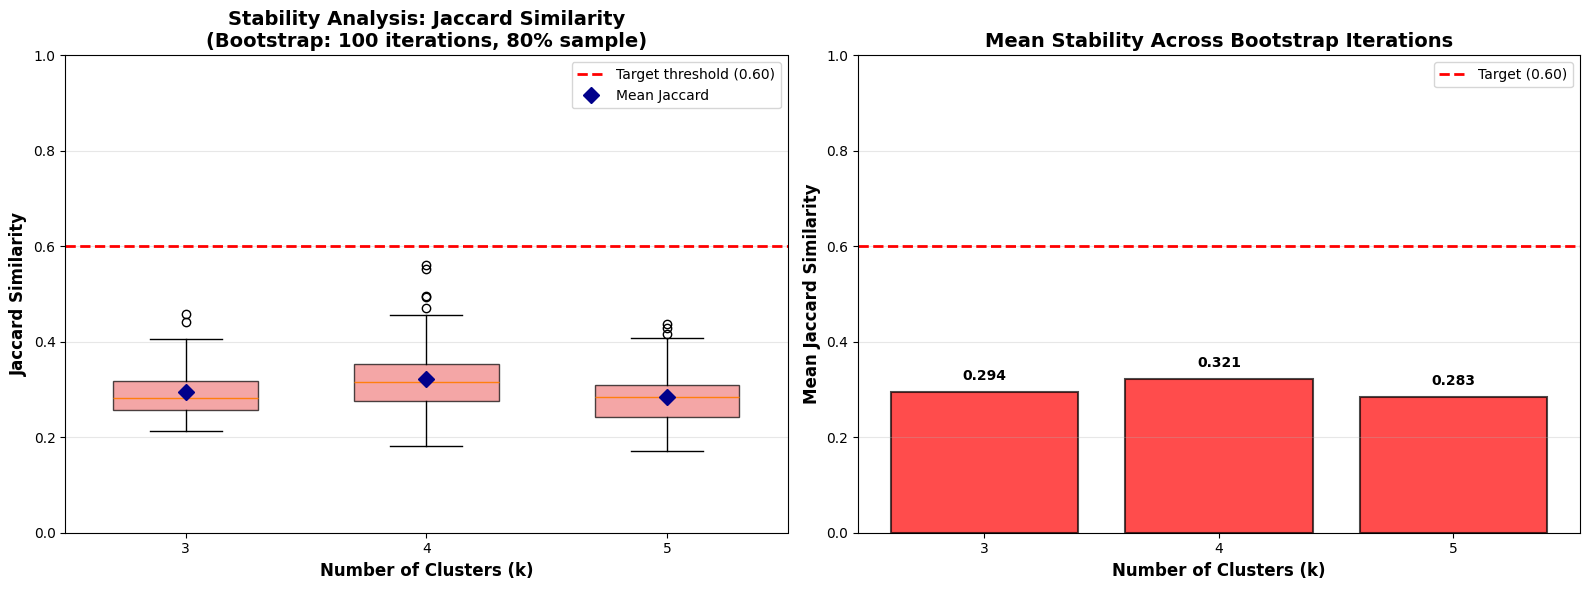


Stability Summary:

k values meeting stability threshold (mean Jaccard ≥ 0.60): []



In [46]:
# Step 6c: Create stability visualizations
print("Creating stability visualizations...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Box plot of Jaccard scores
jaccard_data = [stability_results[k] for k in k_values]
bp = ax1.boxplot(jaccard_data, labels=k_values, patch_artist=True, widths=0.6)

# Color boxes based on mean threshold
for patch, k in zip(bp['boxes'], k_values):
    if stability_summary[k]['meets_threshold']:
        patch.set_facecolor('lightgreen')
    else:
        patch.set_facecolor('lightcoral')
    patch.set_alpha(0.7)

# Add threshold line
ax1.axhline(y=0.60, color='red', linestyle='--', linewidth=2, label='Target threshold (0.60)')

# Add mean points
means = [stability_summary[k]['mean'] for k in k_values]
ax1.plot(range(1, len(k_values) + 1), means, 'D', color='darkblue', 
         markersize=8, label='Mean Jaccard', zorder=3)

ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Jaccard Similarity', fontsize=12, fontweight='bold')
ax1.set_title(f'Stability Analysis: Jaccard Similarity\n(Bootstrap: {n_bootstrap} iterations, 80% sample)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1])

# Plot 2: Mean Jaccard by k
colors_stability = ['green' if stability_summary[k]['meets_threshold'] else 'red' for k in k_values]
ax2.bar(k_values, means, color=colors_stability, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0.60, color='red', linestyle='--', linewidth=2, label='Target (0.60)')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Jaccard Similarity', fontsize=12, fontweight='bold')
ax2.set_title('Mean Stability Across Bootstrap Iterations', fontsize=14, fontweight='bold')
ax2.set_xticks(k_values)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, 1])

# Add value labels
for k, mean_val in zip(k_values, means):
    ax2.text(k, mean_val + 0.02, f'{mean_val:.3f}', ha='center', va='bottom',
             fontsize=10, fontweight='bold')

plt.tight_layout()
output_path = output_dir / "stability_analysis.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")
print("Stability Summary:")
print(f"{'='*60}\n")
print("k values meeting stability threshold (mean Jaccard ≥ 0.60):", 
      [k for k in k_values if stability_summary[k]['meets_threshold']])
print(f"\n{'='*60}")


## Step 7: Clinical Validation


In [47]:
# Step 7a: Compute clinical profiles for each k
print(f"{'='*60}")
print("Step 7: Clinical Validation")
print(f"{'='*60}\n")

# Clinical features to profile 
# IMPORTANT: Merge back with original features for comprehensive profiling
# even though some features weren't used in clustering (like bmi_latest, dbp_latest)
print("Merging cluster labels with full feature set for profiling...")
print(f"Note: Clustering used 8 optimized features, profiling shows all metrics\n")

# Create a profiling dataframe by merging i10_features_df with patient_ids
# Use filtered cohort (missing-SBP patients excluded)
# Match on PID values since indices were reset
profiling_base = i10_features_df[i10_features_df['pid'].isin(patient_ids.values)].copy()
profiling_base = profiling_base.reset_index(drop=True)
profiling_base['array_index'] = range(len(profiling_base))  # Track position

# Define desired clinical features (check availability in full feature set)
desired_clinical = ['sbp_latest', 'dbp_latest', 'bmi_latest', 'age', 'encounter_count_12m', 'icd3_count']
clinical_features = [f for f in desired_clinical if f in profiling_base.columns]

# Update comorbidity features to match optimized set
# Clustering used: E78, I70 (high prevalence)
# Profiling shows all for completeness
desired_comorbidity = ['has_E78', 'has_I70', 'has_E11', 'has_K76']
comorbidity_features = [f for f in desired_comorbidity if f in profiling_base.columns]

print(f"Available clinical features for profiling: {clinical_features}")
print(f"Available comorbidity features: {comorbidity_features}")
print(f"  (Clustering used: E78, I70 only)")
print(f"Cohort: {len(profiling_base)} patients (filtered for complete SBP)\n")

# Merge cluster labels with original data for profiling
clinical_profiles = {}

for k in k_values:
    print(f"\n{'─'*60}")
    print(f"Clinical Profiles for k={k}")
    print(f"{'─'*60}\n")
    
    labels = clustering_results[k]['labels']
    
    # Create dataframe with labels and ALL features (not just clustering features)
    profile_df = profiling_base.copy()
    profile_df['cluster'] = labels
    
    # Compute summary statistics per cluster
    cluster_profiles = []
    
    for cluster_id in range(k):
        cluster_data = profile_df[profile_df['cluster'] == cluster_id]
        n_patients = len(cluster_data)
        
        profile = {
            'cluster': cluster_id,
            'n_patients': n_patients,
            'pct_patients': (n_patients / len(profile_df)) * 100
        }
        
        # Clinical metrics (median for continuous)
        for feat in clinical_features:
            if feat in cluster_data.columns:
                profile[f'{feat}_median'] = cluster_data[feat].median()
                profile[f'{feat}_mean'] = cluster_data[feat].mean()
                profile[f'{feat}_std'] = cluster_data[feat].std()
        
        # Comorbidity prevalence (percentage)
        for feat in comorbidity_features:
            if feat in cluster_data.columns:
                profile[f'{feat}_pct'] = (cluster_data[feat].sum() / n_patients) * 100
        
        cluster_profiles.append(profile)
    
    # Convert to DataFrame
    profiles_df = pd.DataFrame(cluster_profiles)
    clinical_profiles[k] = profiles_df
    
    # Store in clustering_results
    clustering_results[k]['clinical_profiles'] = profiles_df
    
    # Display key metrics
    # Check which features are available (bmi_latest was removed from clustering features)
    has_dbp = 'dbp_latest_median' in profiles_df.columns
    has_bmi = 'bmi_latest_median' in profiles_df.columns
    
    # Build header dynamically
    header_parts = ['Cluster', 'N', '%', 'SBP']
    if has_dbp:
        header_parts.append('DBP')
    if has_bmi:
        header_parts.append('BMI')
    header_parts.append('Encounters')
    
    print(f"{'Cluster':<10} {'N':<8} {'%':<8} {'SBP':<10}", end="")
    if has_dbp:
        print(f" {'DBP':<10}", end="")
    if has_bmi:
        print(f" {'BMI':<10}", end="")
    print(f" {'Encounters':<12}")
    print(f"{'-'*70}")
    
    for _, row in profiles_df.iterrows():
        line = f"{int(row['cluster']):<10} {int(row['n_patients']):<8} {row['pct_patients']:<8.1f} "
        line += f"{row['sbp_latest_median']:<10.1f} "
        if has_dbp:
            line += f"{row['dbp_latest_median']:<10.1f} "
        if has_bmi:
            line += f"{row['bmi_latest_median']:<10.1f} "
        line += f"{row['encounter_count_12m_median']:<12.1f}"
        print(line)
    
    # Check SBP differences (clinical meaningfulness)
    sbp_medians = profiles_df['sbp_latest_median'].values
    max_sbp_diff = sbp_medians.max() - sbp_medians.min()
    sbp_range = f"{sbp_medians.min():.1f} - {sbp_medians.max():.1f}"
    
    print(f"\nSBP range across clusters: {sbp_range} mmHg")
    print(f"Max SBP difference: {max_sbp_diff:.1f} mmHg", end="")
    if max_sbp_diff >= 10:
        print(" ✓ (≥10 mmHg)")
        clustering_results[k]['sbp_clinically_distinct'] = True
    else:
        print(" ✗ (<10 mmHg)")
        clustering_results[k]['sbp_clinically_distinct'] = False

print(f"\n{'='*60}")


Step 7: Clinical Validation

Merging cluster labels with full feature set for profiling...
Note: Clustering used 8 optimized features, profiling shows all metrics

Available clinical features for profiling: ['sbp_latest', 'dbp_latest', 'bmi_latest', 'age', 'encounter_count_12m', 'icd3_count']
Available comorbidity features: ['has_E78', 'has_I70', 'has_E11', 'has_K76']
  (Clustering used: E78, I70 only)
Cohort: 458 patients (filtered for complete SBP)


────────────────────────────────────────────────────────────
Clinical Profiles for k=3
────────────────────────────────────────────────────────────

Cluster    N        %        SBP        DBP        BMI        Encounters  
----------------------------------------------------------------------
0          155      33.8     142.0      88.0       36.0       5.0         
1          93       20.3     139.0      85.0       28.4       7.0         
2          210      45.9     144.0      89.0       30.6       4.0         

SBP range across clust

Creating clinical validation boxplots...



/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/3872686537.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in range(k)],
/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/3872686537.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in range(k)],
/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/3872686537.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in ran

✓ Saved: outputs/visualizations/i10_clustering/clinical_boxplots_k3.png


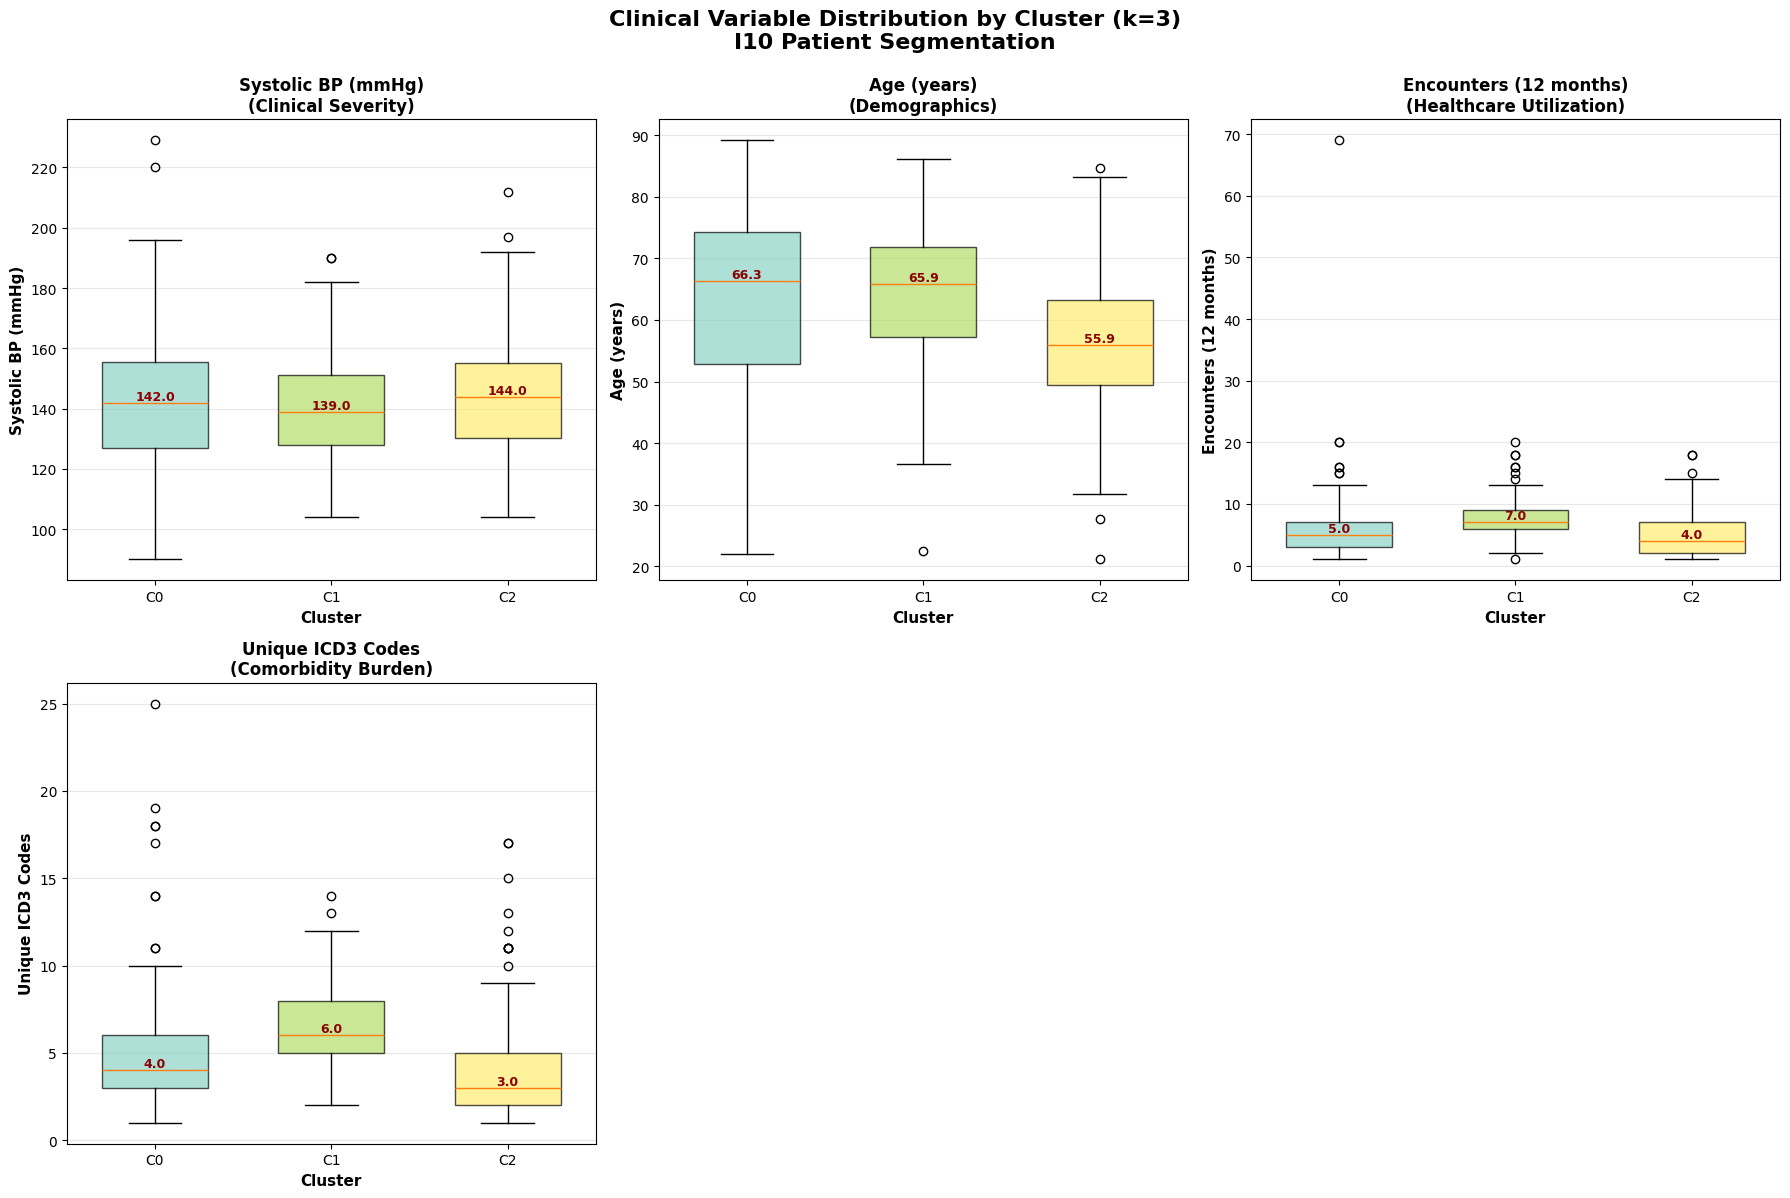

/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/3872686537.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in range(k)],
/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/3872686537.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in range(k)],
/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/3872686537.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in ran

✓ Saved: outputs/visualizations/i10_clustering/clinical_boxplots_k4.png


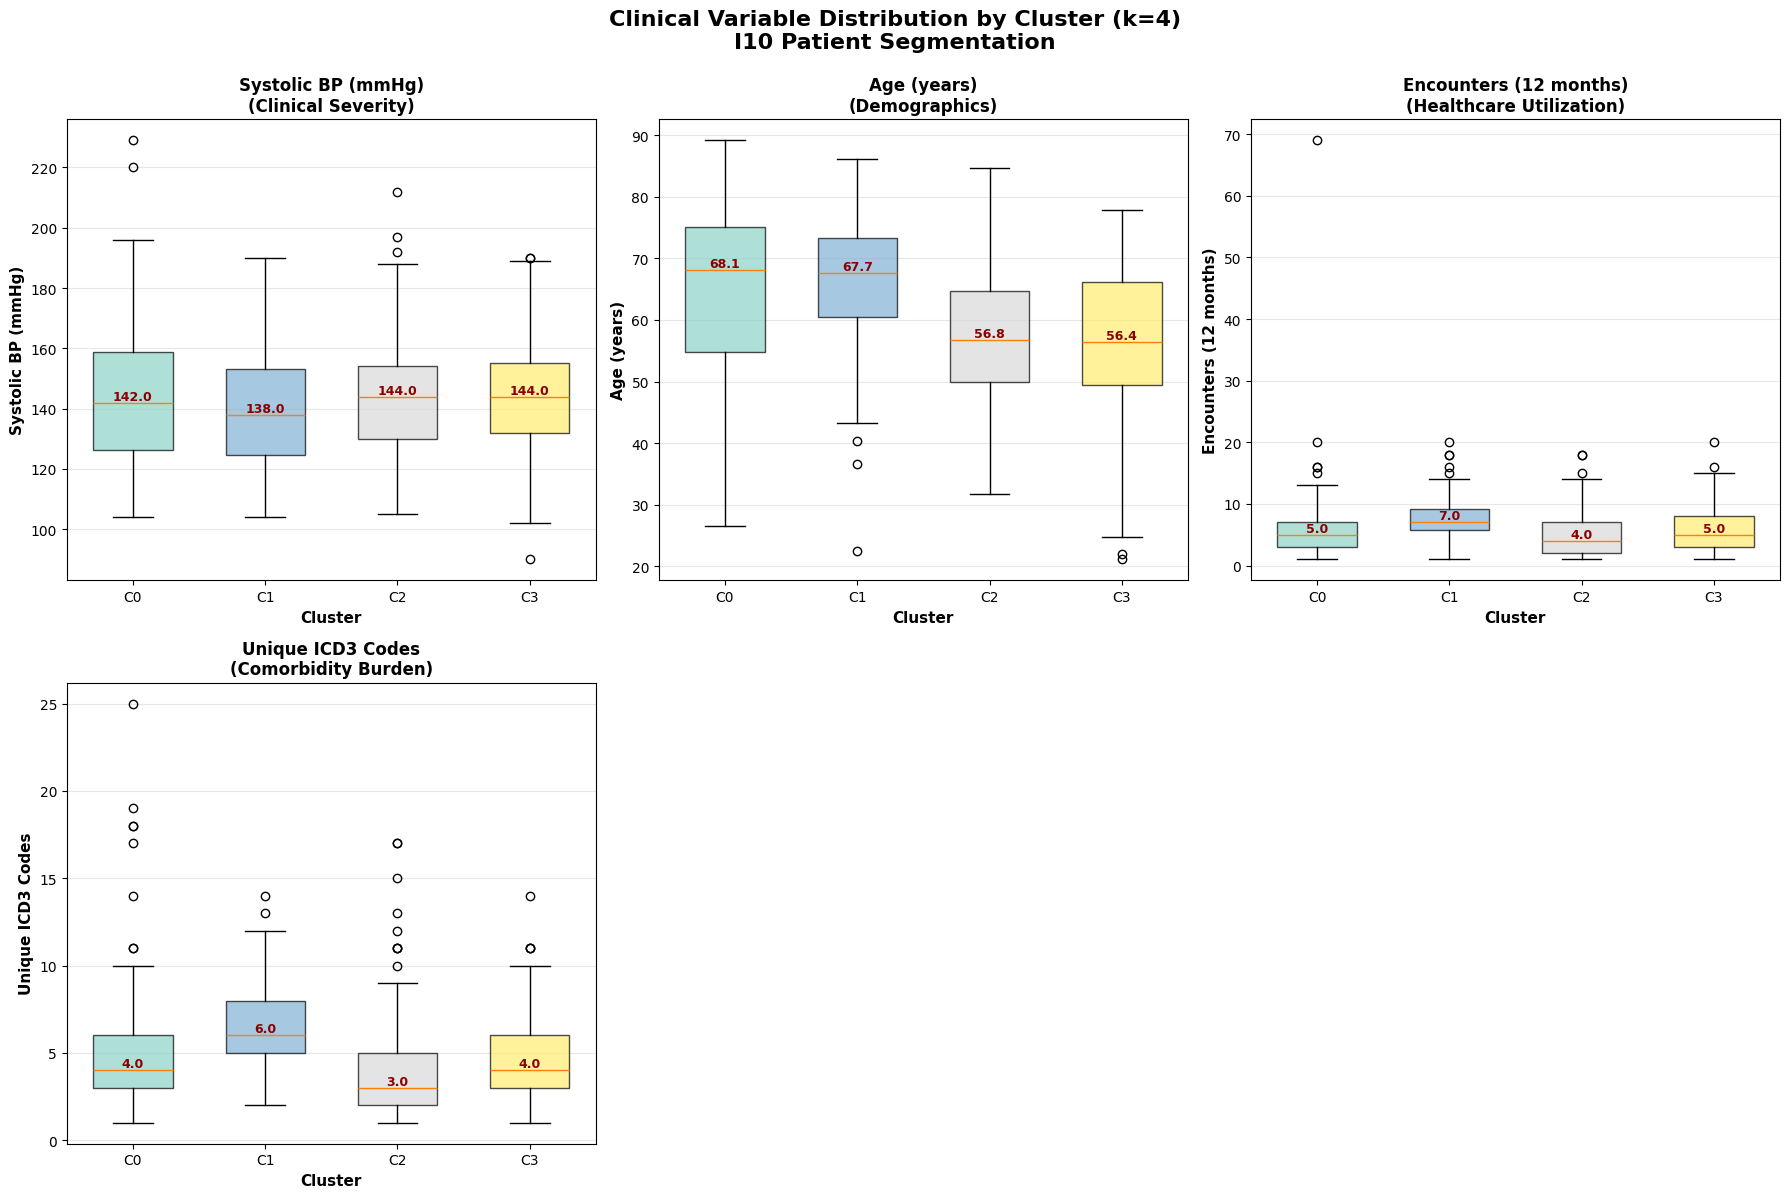

/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/3872686537.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in range(k)],
/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/3872686537.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in range(k)],
/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/3872686537.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in ran

✓ Saved: outputs/visualizations/i10_clustering/clinical_boxplots_k5.png


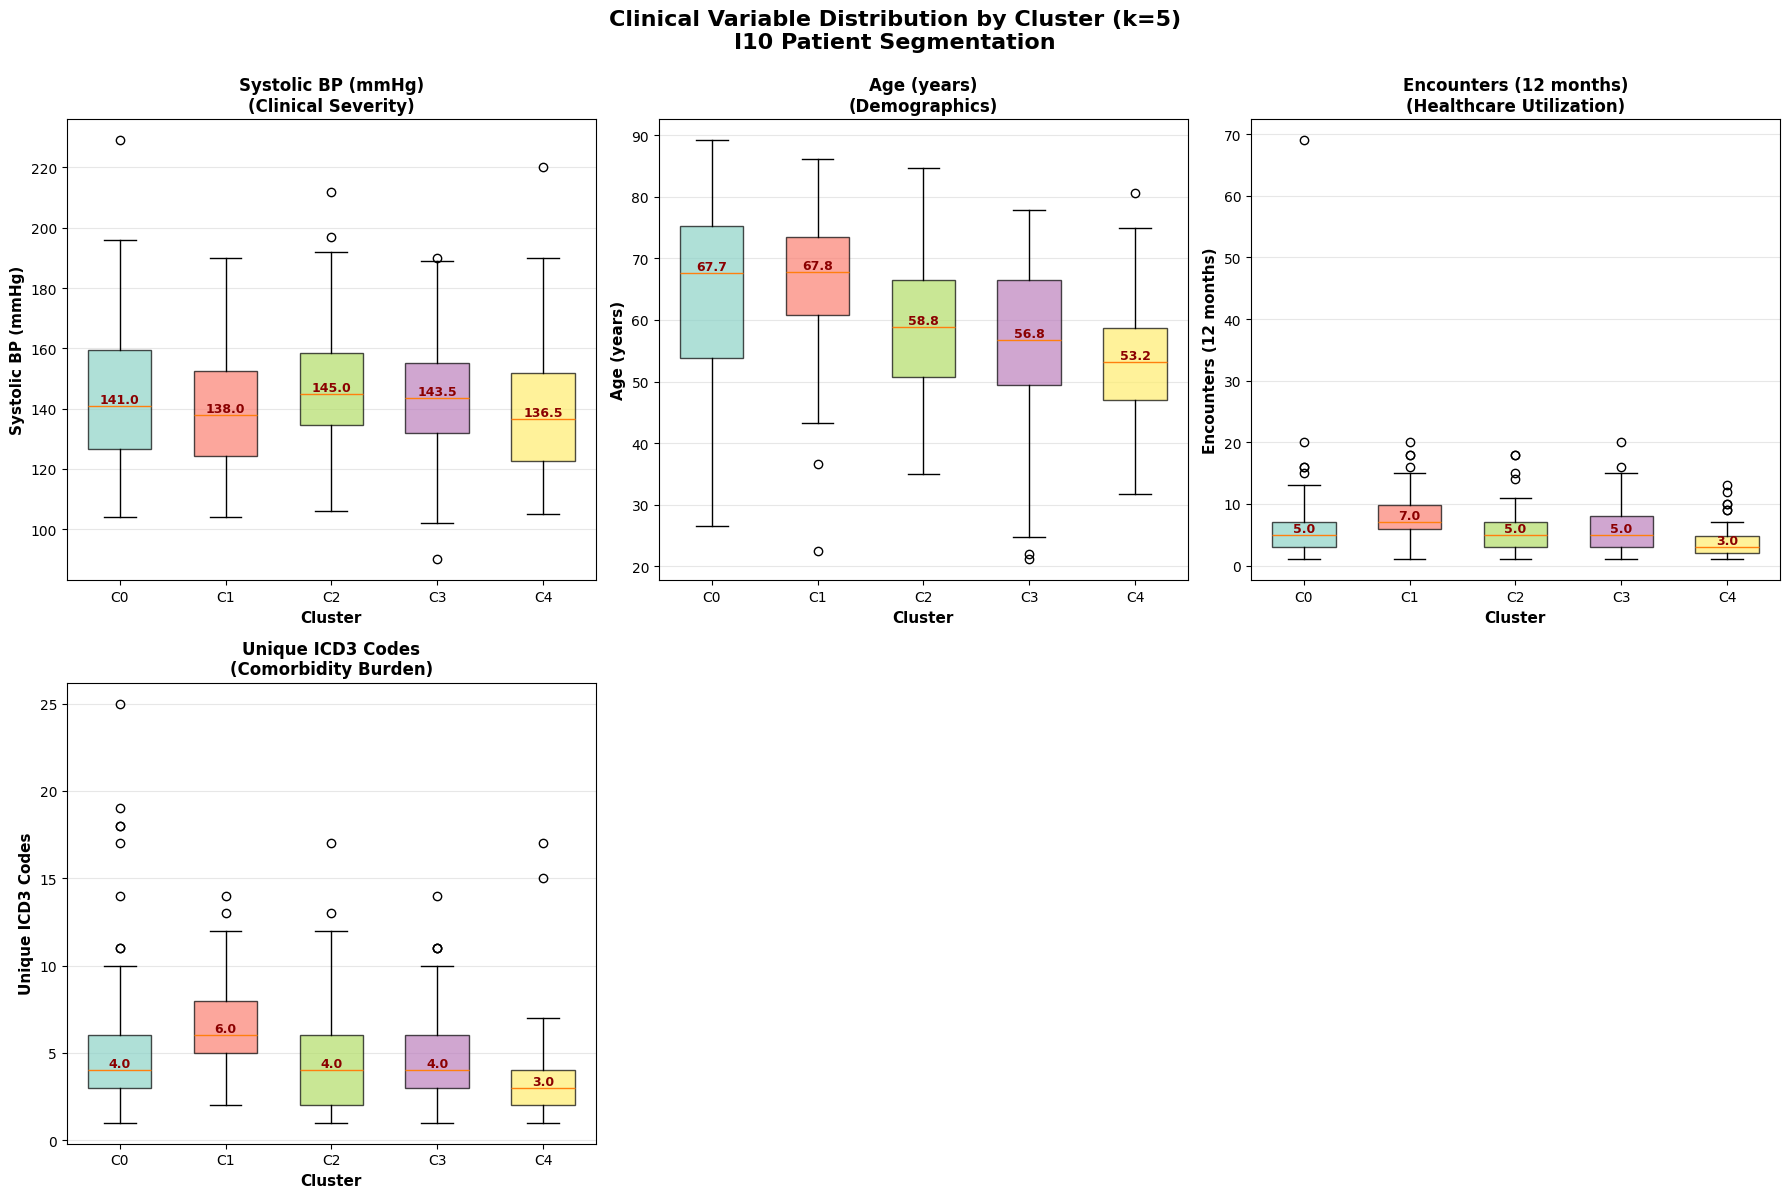

In [48]:
# Step 7b: Create clinical validation visualizations
print("Creating clinical validation boxplots...\n")

# For each k, create a comprehensive clinical comparison plot
for k in k_values:
    labels = clustering_results[k]['labels']
    
    # Create dataframe with labels
    plot_df = clustering_data_clean.copy()
    plot_df['Cluster'] = labels
    
    # Define clinical variables to plot (only those available in the data)
    desired_clinical_vars = [
        ('sbp_latest', 'Systolic BP (mmHg)', 'Clinical Severity'),
        ('dbp_latest', 'Diastolic BP (mmHg)', 'Clinical Severity'),
        ('bmi_latest', 'BMI (kg/m²)', 'Body Composition'),
        ('age', 'Age (years)', 'Demographics'),
        ('encounter_count_12m', 'Encounters (12 months)', 'Healthcare Utilization'),
        ('icd3_count', 'Unique ICD3 Codes', 'Comorbidity Burden')
    ]
    
    # Filter to only available variables
    clinical_vars = [(var, label, cat) for var, label, cat in desired_clinical_vars if var in plot_df.columns]
    
    # Create figure with appropriate number of subplots
    n_vars = len(clinical_vars)
    n_rows = 2
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (var, label, category) in enumerate(clinical_vars):
        ax = axes[idx]
        
        # Create boxplot
        bp = ax.boxplot([plot_df[plot_df['Cluster'] == i][var].dropna() for i in range(k)],
                        labels=[f'C{i}' for i in range(k)],
                        patch_artist=True, widths=0.6)
        
        # Color boxes
        colors_bp = plt.cm.Set3(np.linspace(0, 1, k))
        for patch, color in zip(bp['boxes'], colors_bp):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
        ax.set_ylabel(label, fontsize=11, fontweight='bold')
        ax.set_title(f'{label}\n({category})', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add median values as text
        medians = [plot_df[plot_df['Cluster'] == i][var].median() for i in range(k)]
        for i, median in enumerate(medians):
            ax.text(i + 1, median, f'{median:.1f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold', color='darkred')
    
    # Hide unused subplots
    for idx in range(n_vars, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Clinical Variable Distribution by Cluster (k={k})\nI10 Patient Segmentation',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    output_path = output_dir / f"clinical_boxplots_k{k}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_path}")
    plt.show()

print(f"\n{'='*60}")


In [49]:
# Step 7c: Clinical validation summary
print(f"{'='*60}")
print("Clinical Validation Summary")
print(f"{'='*60}\n")

print(f"{'k':<5} {'SBP Range':<20} {'Max Diff':<12} {'BMI Range':<20} {'Clinically Distinct':<20}")
print(f"{'-'*80}")

for k in k_values:
    profiles = clinical_profiles[k]
    
    sbp_medians = profiles['sbp_latest_median'].values
    sbp_range = f"{sbp_medians.min():.1f}-{sbp_medians.max():.1f}"
    max_sbp_diff = sbp_medians.max() - sbp_medians.min()
    
    bmi_medians = profiles['bmi_latest_median'].values
    bmi_range = f"{bmi_medians.min():.1f}-{bmi_medians.max():.1f}"
    
    is_distinct = "✓" if clustering_results[k]['sbp_clinically_distinct'] else "✗"
    
    print(f"{k:<5} {sbp_range:<20} {max_sbp_diff:<12.1f} {bmi_range:<20} {is_distinct:<20}")

print(f"\nk values with clinically distinct SBP (≥10 mmHg difference):",
      [k for k in k_values if clustering_results[k]['sbp_clinically_distinct']])

print(f"\n{'='*60}")


Clinical Validation Summary

k     SBP Range            Max Diff     BMI Range            Clinically Distinct 
--------------------------------------------------------------------------------
3     139.0-144.0          5.0          28.4-36.0            ✗                   
4     138.0-144.0          6.0          28.3-36.2            ✗                   
5     136.5-145.0          8.5          24.7-36.2            ✗                   

k values with clinically distinct SBP (≥10 mmHg difference): []



## Step 8: Optimal k Selection


In [50]:
# Step 8: Select optimal k based on all criteria
print(f"{'='*60}")
print("Step 8: Optimal k Selection")
print(f"{'='*60}\n")

# Define selection criteria
print("Selection criteria:")
print("  1. Silhouette score ≥ 0.15 (preferably ≥ 0.20)")
print("  2. Stability (mean Jaccard) ≥ 0.60")
print("  3. All clusters ≥ 5% of cohort")
print("  4. SBP difference ≥ 10 mmHg (clinical distinctness)")
print("  5. Prefer smallest k that meets all criteria")
print()

# Create comprehensive comparison table
print(f"\n{'='*60}")
print("Comprehensive Evaluation Summary")
print(f"{'='*60}\n")

comparison_data = []
for k in k_values:
    result = clustering_results[k]
    
    row = {
        'k': k,
        'silhouette': result['silhouette'],
        'stability': result['stability_mean'],
        'size_ok': result['meets_size_threshold'],
        'sbp_distinct': result['sbp_clinically_distinct'],
        'min_cluster_size': min(result['cluster_sizes'].values()),
        'min_cluster_pct': (min(result['cluster_sizes'].values()) / len(clustering_data_clean)) * 100
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Check which k values meet all criteria
comparison_df['meets_silhouette_min'] = comparison_df['silhouette'] >= 0.15
comparison_df['meets_silhouette_good'] = comparison_df['silhouette'] >= 0.20
comparison_df['meets_stability'] = comparison_df['stability'] >= 0.60
comparison_df['meets_all_min'] = (comparison_df['meets_silhouette_min'] & 
                                   comparison_df['meets_stability'] & 
                                   comparison_df['size_ok'] & 
                                   comparison_df['sbp_distinct'])
comparison_df['meets_all_good'] = (comparison_df['meets_silhouette_good'] & 
                                    comparison_df['meets_stability'] & 
                                    comparison_df['size_ok'] & 
                                    comparison_df['sbp_distinct'])

# Display comparison table
print(f"{'k':<5} {'Silhouette':<12} {'Stability':<12} {'Size ≥5%':<10} {'SBP ≥10':<10} {'Meets Min':<12} {'Meets Good':<12}")
print(f"{'-'*85}")
for _, row in comparison_df.iterrows():
    k_val = int(row['k'])
    sil = row['silhouette']
    stab = row['stability']
    size = "✓" if row['size_ok'] else "✗"
    sbp = "✓" if row['sbp_distinct'] else "✗"
    meets_min = "✓" if row['meets_all_min'] else "✗"
    meets_good = "✓" if row['meets_all_good'] else "✗"
    
    print(f"{k_val:<5} {sil:<12.4f} {stab:<12.4f} {size:<10} {sbp:<10} {meets_min:<12} {meets_good:<12}")

print(f"\n{'='*60}")
print("Decision Logic:")
print(f"{'='*60}\n")

# Find k values that meet criteria
k_meets_all_good = comparison_df[comparison_df['meets_all_good']]['k'].tolist()
k_meets_all_min = comparison_df[comparison_df['meets_all_min']]['k'].tolist()

if k_meets_all_good:
    optimal_k = min(k_meets_all_good)
    print(f"✓ k values meeting ALL criteria (silhouette ≥ 0.20): {k_meets_all_good}")
    print(f"✓ RECOMMENDED k = {optimal_k} (smallest k meeting all good criteria)")
    recommendation_level = "STRONG"
elif k_meets_all_min:
    optimal_k = min(k_meets_all_min)
    print(f"⚠ No k meets all criteria with silhouette ≥ 0.20")
    print(f"✓ k values meeting minimum criteria (silhouette ≥ 0.15): {k_meets_all_min}")
    print(f"✓ RECOMMENDED k = {optimal_k} (smallest k meeting minimum criteria)")
    recommendation_level = "MODERATE"
else:
    # Fall back to best compromise
    print(f"⚠ No k meets all criteria")
    print(f"\nEvaluating best compromise...")
    
    # Score each k (higher is better)
    comparison_df['score'] = (
        comparison_df['meets_silhouette_min'].astype(int) * 2 +
        comparison_df['meets_stability'].astype(int) * 2 +
        comparison_df['size_ok'].astype(int) * 1 +
        comparison_df['sbp_distinct'].astype(int) * 1
    )
    
    # Among highest scores, pick smallest k
    max_score = comparison_df['score'].max()
    best_k_candidates = comparison_df[comparison_df['score'] == max_score]['k'].tolist()
    optimal_k = min(best_k_candidates)
    
    print(f"✓ Best compromise k = {optimal_k} (highest score: {max_score}/6, smallest k)")
    recommendation_level = "COMPROMISE"

print(f"\n{'='*60}")
print(f"FINAL RECOMMENDATION: k = {optimal_k}")
print(f"Recommendation level: {recommendation_level}")
print(f"{'='*60}\n")

# Display detailed metrics for optimal k
print(f"Detailed metrics for k = {optimal_k}:")
print(f"  Silhouette score: {clustering_results[optimal_k]['silhouette']:.4f}")
print(f"  Stability (Jaccard): {clustering_results[optimal_k]['stability_mean']:.4f}")
print(f"  Cluster size range: {min(clustering_results[optimal_k]['cluster_sizes'].values())}-{max(clustering_results[optimal_k]['cluster_sizes'].values())} patients")
print(f"  SBP clinical distinction: {'Yes' if clustering_results[optimal_k]['sbp_clinically_distinct'] else 'No'}")
print()

# Display cluster breakdown
print(f"Cluster breakdown for k = {optimal_k}:")
profiles = clinical_profiles[optimal_k]
for _, row in profiles.iterrows():
    cluster_id = int(row['cluster'])
    n = int(row['n_patients'])
    pct = row['pct_patients']
    sbp = row['sbp_latest_median']
    bmi = row['bmi_latest_median']
    enc = row['encounter_count_12m_median']
    print(f"  Cluster {cluster_id}: n={n:3d} ({pct:5.1f}%), SBP={sbp:.1f}, BMI={bmi:.1f}, Encounters={enc:.1f}")

# Store optimal k
optimal_k_selected = optimal_k

print(f"\n{'='*60}")


Step 8: Optimal k Selection

Selection criteria:
  1. Silhouette score ≥ 0.15 (preferably ≥ 0.20)
  2. Stability (mean Jaccard) ≥ 0.60
  3. All clusters ≥ 5% of cohort
  4. SBP difference ≥ 10 mmHg (clinical distinctness)
  5. Prefer smallest k that meets all criteria


Comprehensive Evaluation Summary

k     Silhouette   Stability    Size ≥5%   SBP ≥10    Meets Min    Meets Good  
-------------------------------------------------------------------------------------
3     0.1470       0.2941       ✓          ✗          ✗            ✗           
4     0.2030       0.3211       ✓          ✗          ✗            ✗           
5     0.1972       0.2834       ✓          ✗          ✗            ✗           

Decision Logic:

⚠ No k meets all criteria

Evaluating best compromise...
✓ Best compromise k = 4 (highest score: 3/6, smallest k)

FINAL RECOMMENDATION: k = 4
Recommendation level: COMPROMISE

Detailed metrics for k = 4:
  Silhouette score: 0.2030
  Stability (Jaccard): 0.3211
  Cluster

In [51]:
# Step 9a: Generate final clustering results with optimal k
print(f"{'='*60}")
print(f"Step 9: Final Clustering Results (k={optimal_k_selected})")
print(f"{'='*60}\n")

# Get final clustering results
final_model = clustering_results[optimal_k_selected]['model']
final_labels = clustering_results[optimal_k_selected]['labels']
final_medoid_indices = clustering_results[optimal_k_selected]['medoid_indices']

print(f"Final model parameters:")
print(f"  Number of clusters: {optimal_k_selected}")
print(f"  Algorithm: K-Medoids (PAM)")
print(f"  Distance metric: Gower")
print(f"  Iterations: {final_model.n_iter_}")
print(f"  Inertia: {final_model.inertia_:.4f}")
print()

# Create comprehensive results dataframe
# Start with patient IDs
final_results_df = pd.DataFrame({
    'pid': patient_ids,
    'cluster': final_labels
})

# Add all original features
for col in clustering_data_clean.columns:
    final_results_df[col] = clustering_data_clean[col].values

# Add cluster label with descriptive name (we'll name them based on clinical profiles)
print(f"\n{'='*60}")
print("Identifying Medoid Patients (Cluster Exemplars)")
print(f"{'='*60}\n")

medoid_descriptions = []
for cluster_id, medoid_idx in enumerate(final_medoid_indices):
    medoid_pid = patient_ids.iloc[medoid_idx]
    # Use clustering_data_clean for medoid data (refined features)
    medoid_data = clustering_data_clean.iloc[medoid_idx]
    # Also get from full features if available for additional info
    medoid_full = profiling_base.iloc[medoid_idx] if 'profiling_base' in locals() else medoid_data
    
    print(f"Cluster {cluster_id} Medoid:")
    print(f"  Patient ID: {medoid_pid}")
    print(f"  SBP: {medoid_data['sbp_latest']:.1f} mmHg")
    if 'dbp_latest' in medoid_data.index:
        print(f"  DBP: {medoid_data['dbp_latest']:.1f} mmHg")
    # Try to get BMI from full features, fall back to bmi_class if not available
    if 'bmi_latest' in medoid_full.index:
        print(f"  BMI: {medoid_full['bmi_latest']:.1f}")
    elif 'bmi_class' in medoid_data.index:
        print(f"  BMI Class: {medoid_data['bmi_class']}")
    print(f"  Age: {medoid_data['age']:.0f} years")
    print(f"  Encounters (12m): {medoid_data['encounter_count_12m']}")
    print(f"  ICD3 count: {medoid_data['icd3_count']}")
    print()
    
    medoid_descriptions.append({
        'cluster': cluster_id,
        'medoid_pid': medoid_pid,
        'medoid_idx': medoid_idx
    })

print(f"{'='*60}")


Step 9: Final Clustering Results (k=4)

Final model parameters:
  Number of clusters: 4
  Algorithm: K-Medoids (PAM)
  Distance metric: Gower
  Iterations: 2
  Inertia: 65.5166


Identifying Medoid Patients (Cluster Exemplars)

Cluster 0 Medoid:
  Patient ID: a5351c21ddda7f0770ebfbb08f2d45388fce5408da39074c80bb4a70b76c377a
  SBP: 131.0 mmHg
  BMI: 37.6
  Age: 67 years
  Encounters (12m): 4
  ICD3 count: 4

Cluster 1 Medoid:
  Patient ID: 66933db381485094782ac4a0f2e824ea857e13658b7e87350126bafddeeddbe7
  SBP: 140.0 mmHg
  BMI: 27.2
  Age: 65 years
  Encounters (12m): 6
  ICD3 count: 6

Cluster 2 Medoid:
  Patient ID: e280e5bb2b2f87dc7c2f6961317f68e161a3b1d1694e297d61c3a93aa5ac73fa
  SBP: 144.0 mmHg
  BMI: 34.0
  Age: 58 years
  Encounters (12m): 4
  ICD3 count: 3

Cluster 3 Medoid:
  Patient ID: 08c1a6a119f455f0b9bb3ec4eccad6b7d0b67a67891464a727c1054fd7992bd8
  SBP: 145.0 mmHg
  BMI: 32.8
  Age: 54 years
  Encounters (12m): 6
  ICD3 count: 5



In [52]:
# Step 9b: Create comprehensive cluster profiles
print(f"{'='*60}")
print("Comprehensive Cluster Profiles")
print(f"{'='*60}\n")

final_profiles = clinical_profiles[optimal_k_selected].copy()

# Add additional profile information
for cluster_id in range(optimal_k_selected):
    cluster_mask = final_labels == cluster_id
    cluster_data = clustering_data_clean[cluster_mask]
    # Use profiling_base for features not in clustering set
    cluster_full_data = profiling_base[cluster_mask] if 'profiling_base' in locals() else cluster_data
    
    # Add additional statistics
    final_profiles.loc[cluster_id, 'age_min'] = cluster_data['age'].min()
    final_profiles.loc[cluster_id, 'age_max'] = cluster_data['age'].max()
    final_profiles.loc[cluster_id, 'sbp_min'] = cluster_data['sbp_latest'].min()
    final_profiles.loc[cluster_id, 'sbp_max'] = cluster_data['sbp_latest'].max()
    
    # BMI stats - use full data if available
    if 'bmi_latest' in cluster_full_data.columns:
        final_profiles.loc[cluster_id, 'bmi_min'] = cluster_full_data['bmi_latest'].min()
        final_profiles.loc[cluster_id, 'bmi_max'] = cluster_full_data['bmi_latest'].max()
    
    # Gender distribution
    if 'sex' in cluster_data.columns:
        gender_counts = cluster_data['sex'].value_counts()
        for gender in gender_counts.index:
            final_profiles.loc[cluster_id, f'sex_{gender}_pct'] = (gender_counts[gender] / len(cluster_data)) * 100
    
    # BP stage distribution - only if available
    if 'bp_stage' in cluster_full_data.columns:
        bp_stage_counts = cluster_full_data['bp_stage'].value_counts()
        for stage in bp_stage_counts.index:
            final_profiles.loc[cluster_id, f'bp_stage_{stage}_pct'] = (bp_stage_counts[stage] / len(cluster_full_data)) * 100

# Display comprehensive profile table
print("Cluster Profiles Summary:\n")
for cluster_id in range(optimal_k_selected):
    row = final_profiles.iloc[cluster_id]
    print(f"{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"Size: {int(row['n_patients'])} patients ({row['pct_patients']:.1f}% of cohort)")
    print()
    print(f"Clinical Metrics (Median ± Std):")
    print(f"  SBP: {row['sbp_latest_median']:.1f} ± {row['sbp_latest_std']:.1f} mmHg (range: {row['sbp_min']:.1f}-{row['sbp_max']:.1f})")
    if 'dbp_latest_median' in row.index:
        print(f"  DBP: {row['dbp_latest_median']:.1f} ± {row['dbp_latest_std']:.1f} mmHg")
    # BMI - check if available (may not be in clustering features)
    if 'bmi_latest_median' in row.index and pd.notna(row.get('bmi_min')):
        print(f"  BMI: {row['bmi_latest_median']:.1f} ± {row['bmi_latest_std']:.1f} (range: {row['bmi_min']:.1f}-{row['bmi_max']:.1f})")
    elif 'bmi_latest_median' in row.index:
        print(f"  BMI: {row['bmi_latest_median']:.1f} ± {row['bmi_latest_std']:.1f}")
    print(f"  Age: {row['age_median']:.0f} ± {row['age_std']:.1f} years (range: {row['age_min']:.0f}-{row['age_max']:.0f})")
    print()
    print(f"Healthcare Utilization:")
    print(f"  Encounters (12m): {row['encounter_count_12m_median']:.1f} ± {row['encounter_count_12m_std']:.1f}")
    print(f"  ICD3 codes: {row['icd3_count_median']:.1f} ± {row['icd3_count_std']:.1f}")
    print()
    print(f"Comorbidities (% with condition):")
    print(f"  Diabetes (E11): {row['has_E11_pct']:.1f}%")
    print(f"  Dyslipidemia (E78): {row['has_E78_pct']:.1f}%")
    print(f"  Liver disease (K76): {row['has_K76_pct']:.1f}%")
    print(f"  Atherosclerosis (I70): {row['has_I70_pct']:.1f}%")
    print()

print(f"{'='*70}\n")


Comprehensive Cluster Profiles

Cluster Profiles Summary:

CLUSTER 0
Size: 106 patients (23.1% of cohort)

Clinical Metrics (Median ± Std):
  SBP: 142.0 ± 22.3 mmHg (range: 104.0-229.0)
  DBP: 86.5 ± 12.9 mmHg
  BMI: 36.2 ± 9.2 (range: 15.6-73.5)
  Age: 68 ± 13.4 years (range: 27-89)

Healthcare Utilization:
  Encounters (12m): 5.0 ± 7.2
  ICD3 codes: 4.0 ± 4.1

Comorbidities (% with condition):
  Diabetes (E11): 6.6%
  Dyslipidemia (E78): 2.8%
  Liver disease (K76): 9.4%
  Atherosclerosis (I70): 12.3%

CLUSTER 1
Size: 76 patients (16.6% of cohort)

Clinical Metrics (Median ± Std):
  SBP: 138.0 ± 20.2 mmHg (range: 104.0-190.0)
  DBP: 83.0 ± 11.6 mmHg
  BMI: 28.3 ± 4.9 (range: 19.2-44.8)
  Age: 68 ± 11.5 years (range: 22-86)

Healthcare Utilization:
  Encounters (12m): 7.0 ± 3.8
  ICD3 codes: 6.0 ± 2.3

Comorbidities (% with condition):
  Diabetes (E11): 11.8%
  Dyslipidemia (E78): 80.3%
  Liver disease (K76): 6.6%
  Atherosclerosis (I70): 18.4%

CLUSTER 2
Size: 141 patients (30.8% of c

In [53]:
# Step 9c: Generate DATA-ANCHORED cluster names
print(f"{'='*60}")
print("DATA-ANCHORED Cluster Naming")
print(f"{'='*60}\n")

def generate_data_anchored_cluster_name(sbp, bmi, encounters):
    """
    Generate precise, data-anchored cluster name.
    Format: "[BP Level] | [BMI Category] | [Utilization Level]"
    """
    # BP Level classification (based on ACC/AHA guidelines)
    if pd.isna(sbp) or sbp < 100:
        bp_level = "BP-Missing"
    elif sbp < 120:
        bp_level = "Normal-BP"
    elif sbp < 130:
        bp_level = "Elevated-BP"
    elif sbp < 140:
        bp_level = "Stage-1-BP"
    elif sbp < 180:
        bp_level = "Stage-2-BP"
    else:
        bp_level = "Hypertensive-Crisis"
    
    # BMI Category (standard WHO classifications)
    if pd.isna(bmi):
        bmi_cat = "BMI-Unknown"
    elif bmi < 18.5:
        bmi_cat = "Underweight"
    elif bmi < 25:
        bmi_cat = "Normal-Wt"
    elif bmi < 30:
        bmi_cat = "Overweight"
    elif bmi < 35:
        bmi_cat = "Obese-I"
    elif bmi < 40:
        bmi_cat = "Obese-II"
    else:
        bmi_cat = "Obese-III"
    
    # Utilization Level (based on encounter count distribution)
    if pd.isna(encounters):
        util_level = "Util-Unknown"
    elif encounters <= 2:
        util_level = "Low-Util"
    elif encounters <= 5:
        util_level = "Med-Util"
    elif encounters <= 8:
        util_level = "High-Util"
    else:
        util_level = "VHigh-Util"
    
    # Construct data-anchored name
    name = f"{bp_level} | {bmi_cat} | {util_level}"
    
    return name

# Generate names for each cluster
cluster_names = {}
print("Generated Data-Anchored Cluster Names:\n")
print(f"{'Cluster':<10} {'Data-Anchored Name':<50} {'N':<8} {'%':<6}")
print(f"{'-'*80}")

for cluster_id in range(optimal_k_selected):
    row = final_profiles.iloc[cluster_id]
    
    # Get key metrics
    sbp = row['sbp_latest_median']
    # Get BMI - may be in different columns
    bmi = row.get('bmi_latest_median', row.get('bmi_median', np.nan))
    encounters = row['encounter_count_12m_median']
    
    # Generate name
    name = generate_data_anchored_cluster_name(sbp, bmi, encounters)
    cluster_names[cluster_id] = name
    
    # Display
    print(f"{cluster_id:<10} {name:<50} {int(row['n_patients']):<8} {row['pct_patients']:<6.1f}%")

# Add names to final_profiles
final_profiles['cluster_name'] = final_profiles['cluster'].map(cluster_names)

print(f"\n✓ Data-anchored names generated for {optimal_k_selected} clusters")
print(f"✓ Names added to final_profiles DataFrame")
print(f"\nNaming convention: [BP Level] | [BMI Category] | [Utilization Level]")
print(f"  - BP Level: Based on ACC/AHA guidelines (Normal/Elevated/Stage-1/Stage-2)")
print(f"  - BMI Category: Based on WHO classifications (Normal-Wt/Overweight/Obese-I/II/III)")
print(f"  - Utilization: Based on 12-month encounters (Low/Med/High/VHigh)")
print()


DATA-ANCHORED Cluster Naming

Generated Data-Anchored Cluster Names:

Cluster    Data-Anchored Name                                 N        %     
--------------------------------------------------------------------------------
0          Stage-2-BP | Obese-II | Med-Util                   106      23.1  %
1          Stage-1-BP | Overweight | High-Util                76       16.6  %
2          Stage-2-BP | Obese-I | Med-Util                    141      30.8  %
3          Stage-2-BP | Obese-I | Med-Util                    135      29.5  %

✓ Data-anchored names generated for 4 clusters
✓ Names added to final_profiles DataFrame

Naming convention: [BP Level] | [BMI Category] | [Utilization Level]
  - BP Level: Based on ACC/AHA guidelines (Normal/Elevated/Stage-1/Stage-2)
  - BMI Category: Based on WHO classifications (Normal-Wt/Overweight/Obese-I/II/III)
  - Utilization: Based on 12-month encounters (Low/Med/High/VHigh)



In [54]:
# Step 9c: Save clustering results and profiles to CSV
print(f"{'='*60}")
print("Saving Results to Files")
print(f"{'='*60}\n")

# Create output directory for data
output_data_dir = Path("outputs/data")
output_data_dir.mkdir(parents=True, exist_ok=True)

# Save cluster assignments
assignments_path = output_data_dir / "i10_cluster_assignments.csv"
final_results_df.to_csv(assignments_path, index=False)
print(f"✓ Saved cluster assignments: {assignments_path}")
print(f"  Shape: {final_results_df.shape}")
print(f"  Columns: {list(final_results_df.columns)}")

# Save cluster profiles
profiles_path = output_data_dir / "i10_cluster_profiles.csv"
final_profiles.to_csv(profiles_path, index=False)
print(f"\n✓ Saved cluster profiles: {profiles_path}")
print(f"  Shape: {final_profiles.shape}")

# Save medoid information
medoids_df = pd.DataFrame(medoid_descriptions)
medoids_path = output_data_dir / "i10_cluster_medoids.csv"
medoids_df.to_csv(medoids_path, index=False)
print(f"\n✓ Saved medoid information: {medoids_path}")

# Save evaluation metrics summary
eval_summary = {
    'optimal_k': optimal_k_selected,
    'silhouette_score': clustering_results[optimal_k_selected]['silhouette'],
    'stability_jaccard_mean': clustering_results[optimal_k_selected]['stability_mean'],
    'n_patients': len(final_results_df),
    'recommendation_level': recommendation_level
}
eval_df = pd.DataFrame([eval_summary])
eval_path = output_data_dir / "i10_clustering_evaluation.csv"
eval_df.to_csv(eval_path, index=False)
print(f"\n✓ Saved evaluation metrics: {eval_path}")

print(f"\n{'='*60}")


Saving Results to Files

✓ Saved cluster assignments: outputs/data/i10_cluster_assignments.csv
  Shape: (458, 10)
  Columns: ['pid', 'cluster', 'sbp_latest', 'age', 'encounter_count_12m', 'icd3_count', 'bmi_class', 'sex', 'has_E78', 'has_I70']

✓ Saved cluster profiles: outputs/data/i10_cluster_profiles.csv
  Shape: (4, 39)

✓ Saved medoid information: outputs/data/i10_cluster_medoids.csv

✓ Saved evaluation metrics: outputs/data/i10_clustering_evaluation.csv



## Step 10: Final Visualizations


Step 10: Final Visualizations

Creating final visualizations...

✓ Saved: outputs/visualizations/i10_clustering/final_cluster_sizes_k4.png


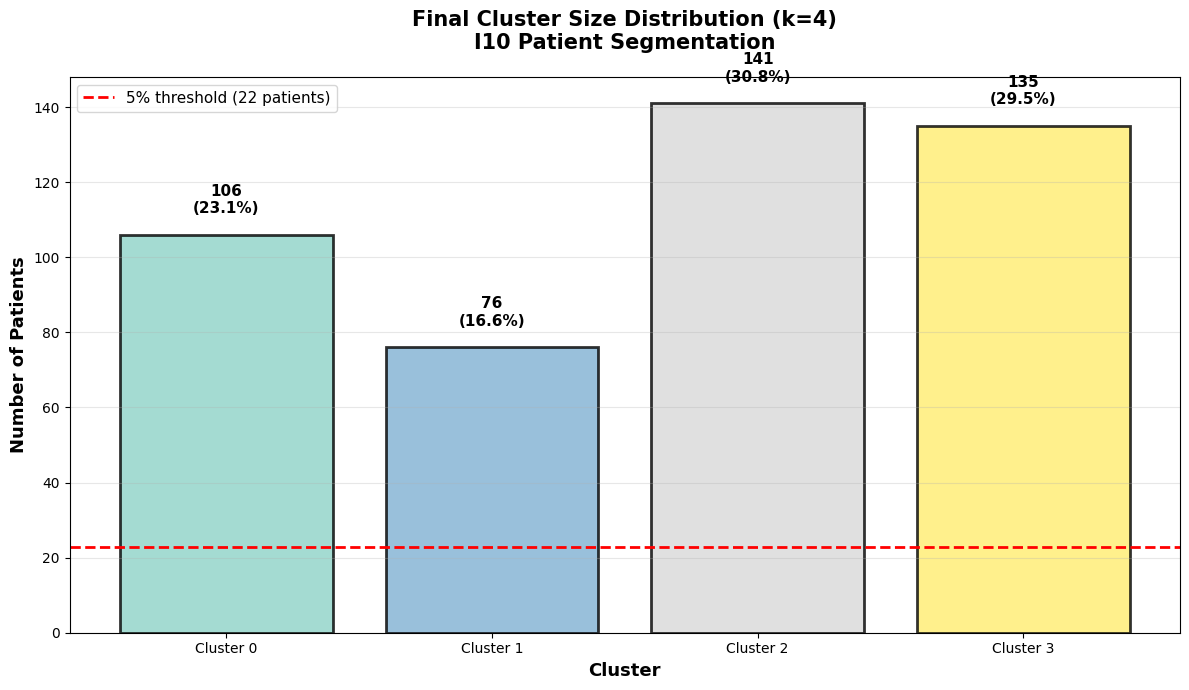

In [55]:
# Step 10a: Cluster size distribution
print(f"{'='*60}")
print("Step 10: Final Visualizations")
print(f"{'='*60}\n")

print("Creating final visualizations...\n")

# Visualization 1: Cluster size distribution
fig, ax = plt.subplots(figsize=(12, 7))

cluster_sizes = [clustering_results[optimal_k_selected]['cluster_sizes'][i] 
                 for i in range(optimal_k_selected)]
cluster_labels = [f'Cluster {i}' for i in range(optimal_k_selected)]
cluster_pcts = [(size / len(final_results_df)) * 100 for size in cluster_sizes]

colors_bar = plt.cm.Set3(np.linspace(0, 1, optimal_k_selected))
bars = ax.bar(cluster_labels, cluster_sizes, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)

# Add value labels on bars
for i, (bar, size, pct) in enumerate(zip(bars, cluster_sizes, cluster_pcts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{size}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add 5% threshold line
threshold_line = 0.05 * len(final_results_df)
ax.axhline(y=threshold_line, color='red', linestyle='--', linewidth=2, 
           label=f'5% threshold ({int(threshold_line)} patients)')

ax.set_xlabel('Cluster', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Patients', fontsize=13, fontweight='bold')
ax.set_title(f'Final Cluster Size Distribution (k={optimal_k_selected})\nI10 Patient Segmentation',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
output_path = output_dir / f"final_cluster_sizes_k{optimal_k_selected}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print()


Creating clinical comparison heatmap...

Heatmap features available: 10/10
✓ Saved: outputs/visualizations/i10_clustering/clinical_profile_heatmap_k4.png


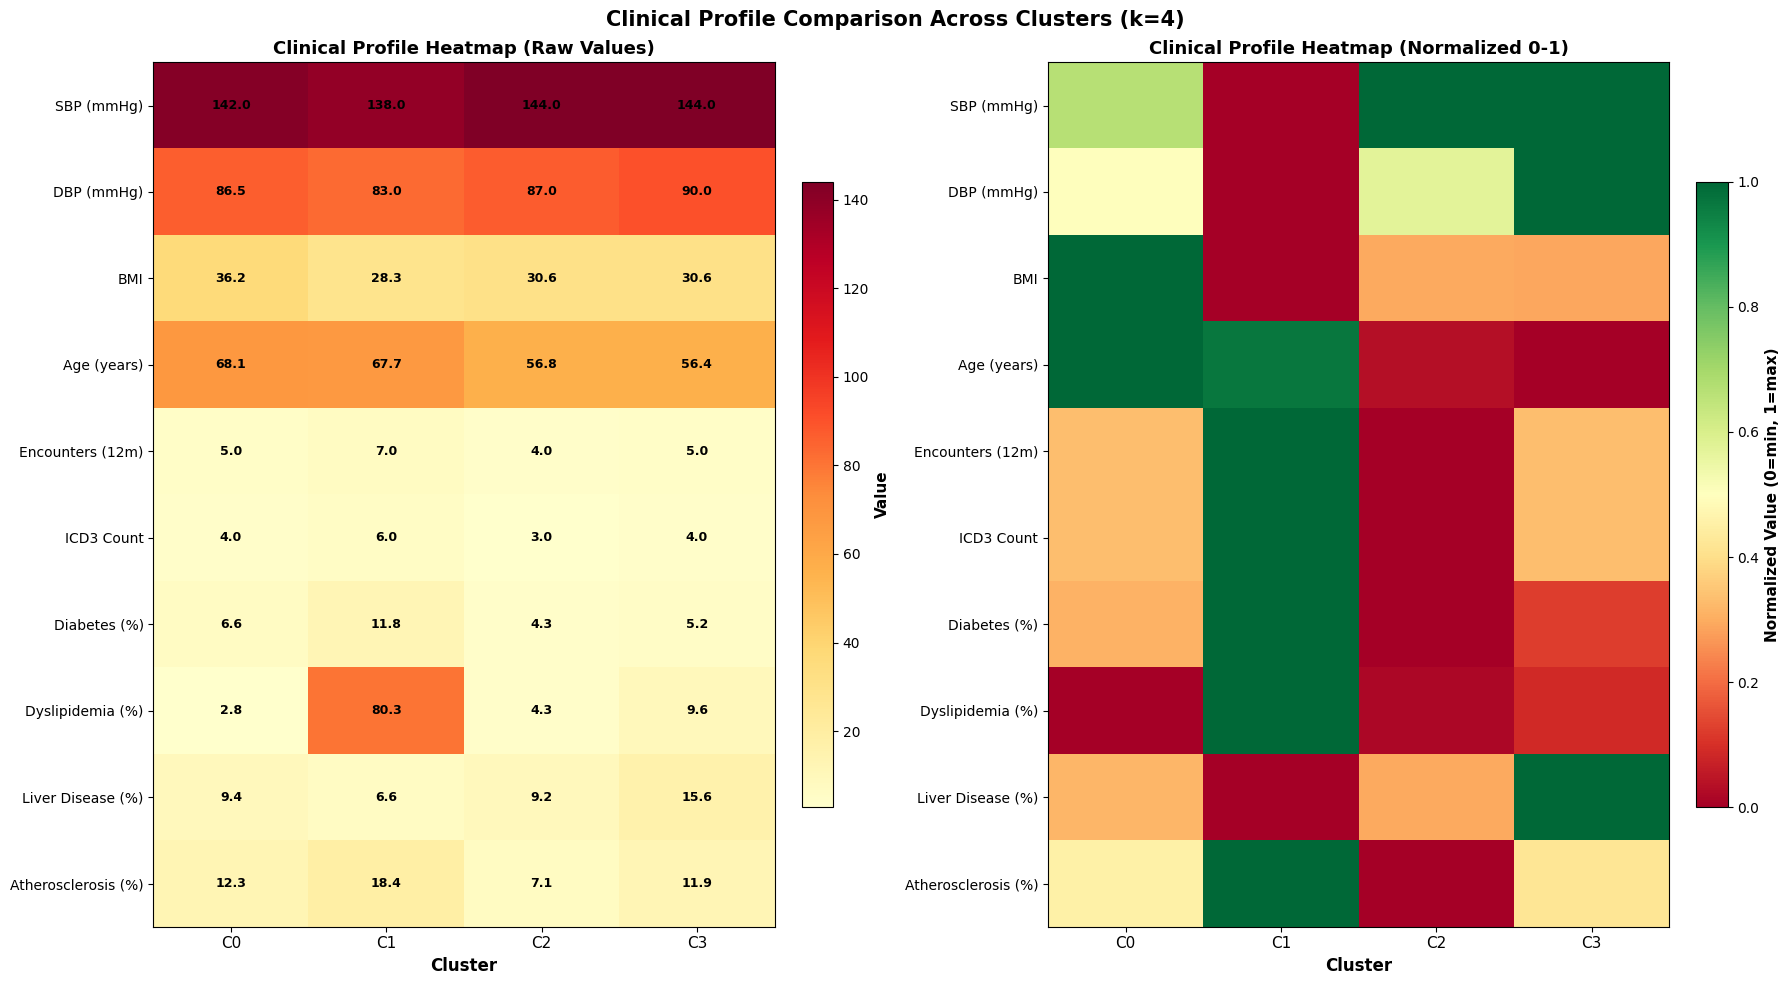

In [56]:
# Step 10b: Clinical comparison heatmap
print("Creating clinical comparison heatmap...\n")

# Prepare data for heatmap (only features that exist in final_profiles)
desired_heatmap_features = [
    ('sbp_latest_median', 'SBP (mmHg)'),
    ('dbp_latest_median', 'DBP (mmHg)'),
    ('bmi_latest_median', 'BMI'),
    ('age_median', 'Age (years)'),
    ('encounter_count_12m_median', 'Encounters (12m)'),
    ('icd3_count_median', 'ICD3 Count'),
    ('has_E11_pct', 'Diabetes (%)'),
    ('has_E78_pct', 'Dyslipidemia (%)'),
    ('has_K76_pct', 'Liver Disease (%)'),
    ('has_I70_pct', 'Atherosclerosis (%)')
]

# Filter to only available features
available_profile_cols = final_profiles.columns.tolist()
heatmap_features = []
heatmap_labels = []
for feat, label in desired_heatmap_features:
    if feat in available_profile_cols:
        heatmap_features.append(feat)
        heatmap_labels.append(label)

print(f"Heatmap features available: {len(heatmap_features)}/{len(desired_heatmap_features)}")

# Extract values for each cluster
heatmap_data = []
for cluster_id in range(optimal_k_selected):
    row_data = []
    for feat in heatmap_features:
        value = final_profiles.loc[cluster_id, feat]
        row_data.append(value)
    heatmap_data.append(row_data)

heatmap_array = np.array(heatmap_data).T  # Transpose so features are rows

# Normalize each feature to 0-1 for better visualization
heatmap_normalized = heatmap_array.copy()
for i in range(len(heatmap_normalized)):
    min_val = heatmap_normalized[i].min()
    max_val = heatmap_normalized[i].max()
    if max_val > min_val:
        heatmap_normalized[i] = (heatmap_normalized[i] - min_val) / (max_val - min_val)

# Create heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Raw values heatmap
im1 = ax1.imshow(heatmap_array, cmap='YlOrRd', aspect='auto')
ax1.set_xticks(np.arange(optimal_k_selected))
ax1.set_yticks(np.arange(len(heatmap_labels)))
ax1.set_xticklabels([f'C{i}' for i in range(optimal_k_selected)], fontsize=11)
ax1.set_yticklabels(heatmap_labels, fontsize=10)
ax1.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax1.set_title('Clinical Profile Heatmap (Raw Values)', fontsize=13, fontweight='bold')

# Add value annotations
for i in range(len(heatmap_labels)):
    for j in range(optimal_k_selected):
        text = ax1.text(j, i, f'{heatmap_array[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label('Value', fontsize=11, fontweight='bold')

# Normalized heatmap
im2 = ax2.imshow(heatmap_normalized, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax2.set_xticks(np.arange(optimal_k_selected))
ax2.set_yticks(np.arange(len(heatmap_labels)))
ax2.set_xticklabels([f'C{i}' for i in range(optimal_k_selected)], fontsize=11)
ax2.set_yticklabels(heatmap_labels, fontsize=10)
ax2.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax2.set_title('Clinical Profile Heatmap (Normalized 0-1)', fontsize=13, fontweight='bold')

cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label('Normalized Value (0=min, 1=max)', fontsize=11, fontweight='bold')

plt.suptitle(f'Clinical Profile Comparison Across Clusters (k={optimal_k_selected})',
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()

output_path = output_dir / f"clinical_profile_heatmap_k{optimal_k_selected}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print()


Creating medoid patient profiles...

Plotting 4 metrics

✓ Saved: outputs/visualizations/i10_clustering/medoid_profiles_k4.png


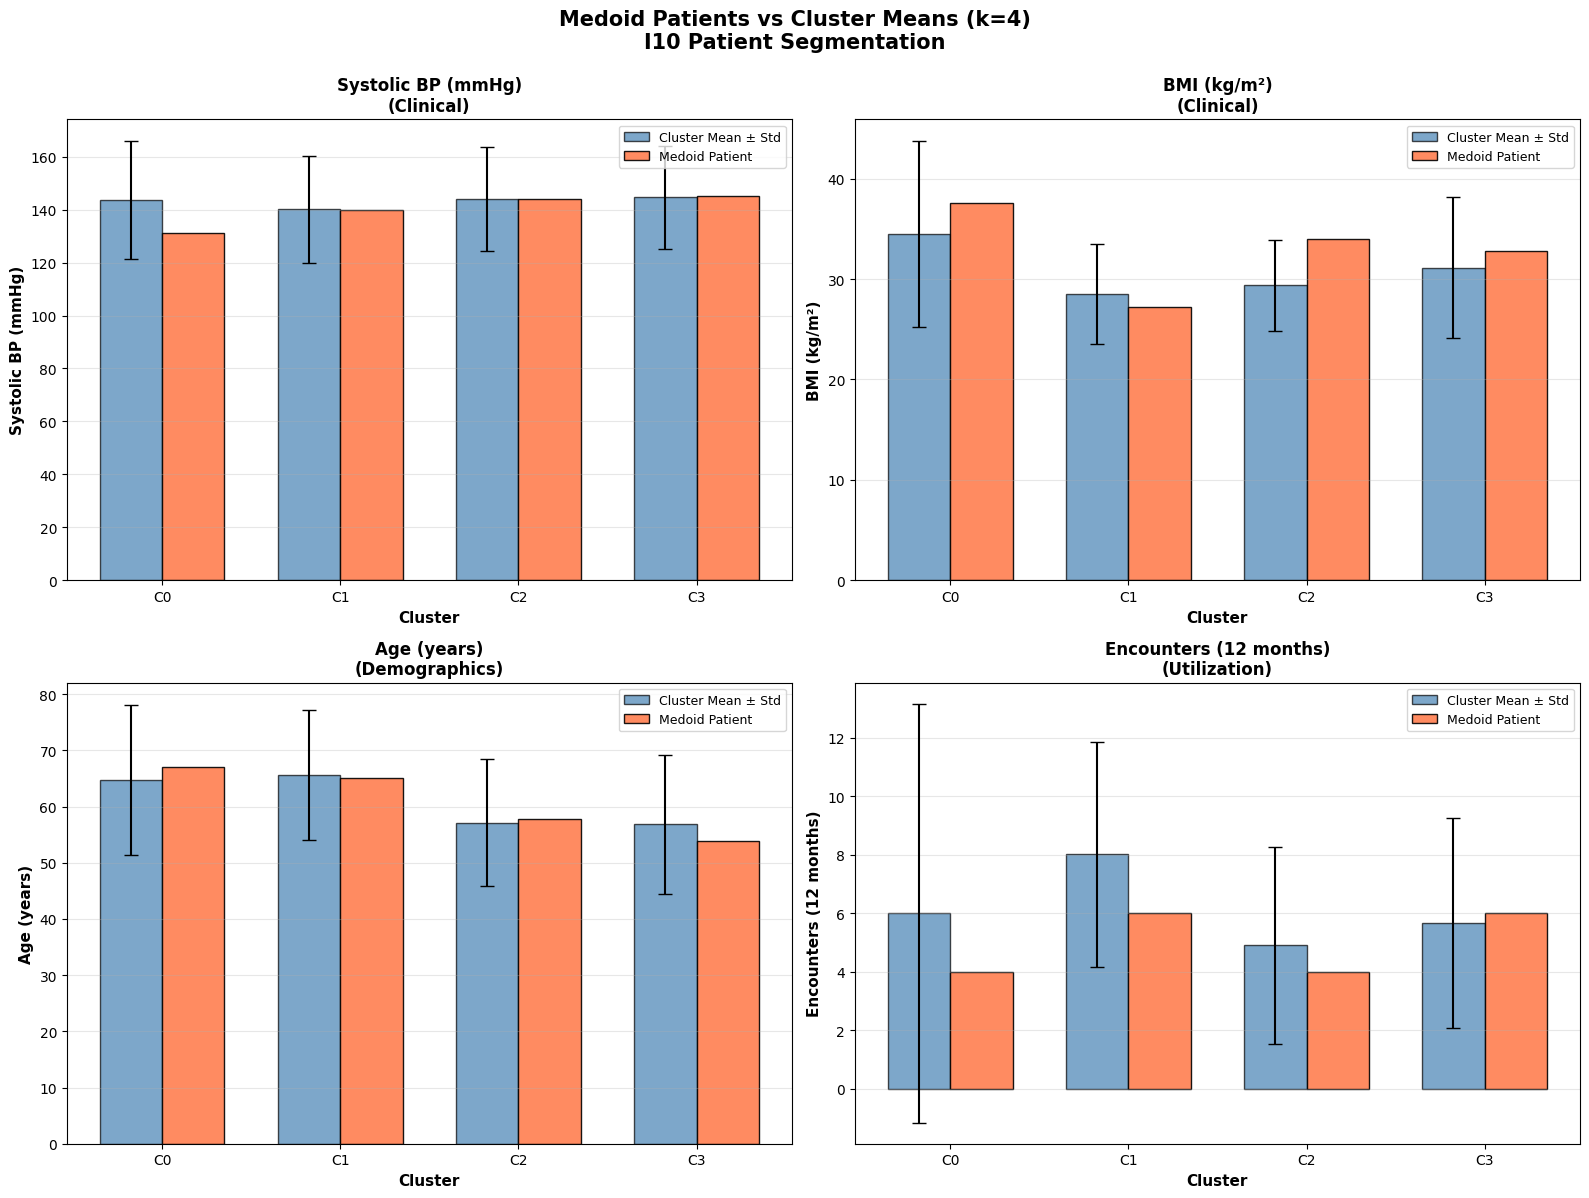

In [57]:
# Step 10c: Medoid patient profiles visualization
print("Creating medoid patient profiles...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Key metrics to compare - filter to available metrics
desired_metrics = [
    ('sbp_latest', 'Systolic BP (mmHg)', 'Clinical'),
    ('bmi_latest', 'BMI (kg/m²)', 'Clinical'),
    ('age', 'Age (years)', 'Demographics'),
    ('encounter_count_12m', 'Encounters (12 months)', 'Utilization')
]

# Filter to only metrics that are available
medoid_metrics = []
for metric, label, category in desired_metrics:
    # Check if metric is in clustering features or profiling base
    if metric in clustering_data_clean.columns:
        medoid_metrics.append((metric, label, category, clustering_data_clean))
    elif 'profiling_base' in locals() and metric in profiling_base.columns:
        medoid_metrics.append((metric, label, category, profiling_base))
    else:
        print(f"⚠ Skipping {label} - not available in data")

print(f"Plotting {len(medoid_metrics)} metrics\n")

for idx, (metric, label, category, data_source) in enumerate(medoid_metrics):
    ax = axes[idx]
    
    # Get medoid values and cluster means
    medoid_values = []
    cluster_means = []
    cluster_stds = []
    
    for cluster_id in range(optimal_k_selected):
        medoid_idx = final_medoid_indices[cluster_id]
        medoid_val = data_source.iloc[medoid_idx][metric]
        medoid_values.append(medoid_val)
        
        cluster_mask = final_labels == cluster_id
        cluster_data = data_source[cluster_mask][metric]
        cluster_means.append(cluster_data.mean())
        cluster_stds.append(cluster_data.std())
    
    x = np.arange(optimal_k_selected)
    width = 0.35
    
    # Plot cluster means with error bars
    bars1 = ax.bar(x - width/2, cluster_means, width, yerr=cluster_stds,
                   label='Cluster Mean ± Std', alpha=0.7, capsize=5,
                   color='steelblue', edgecolor='black')
    
    # Plot medoid values
    bars2 = ax.bar(x + width/2, medoid_values, width,
                   label='Medoid Patient', alpha=0.9,
                   color='coral', edgecolor='black')
    
    ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_ylabel(label, fontsize=11, fontweight='bold')
    ax.set_title(f'{label}\n({category})', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'C{i}' for i in range(optimal_k_selected)])
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

# Hide unused subplots if we have fewer than 4 metrics
for idx in range(len(medoid_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle(f'Medoid Patients vs Cluster Means (k={optimal_k_selected})\nI10 Patient Segmentation',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

output_path = output_dir / f"medoid_profiles_k{optimal_k_selected}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print()


Step 10d: PCA Visualization with Beautiful Colors

✓ No missing values in PCA data

PCA Results:
  PC1 explains: 31.2% of variance
  PC2 explains: 18.9% of variance
  Total variance explained: 50.0%


✓ Saved beautiful PCA visualization: outputs/visualizations/i10_clustering/pca_visualization_beautiful_k4.png


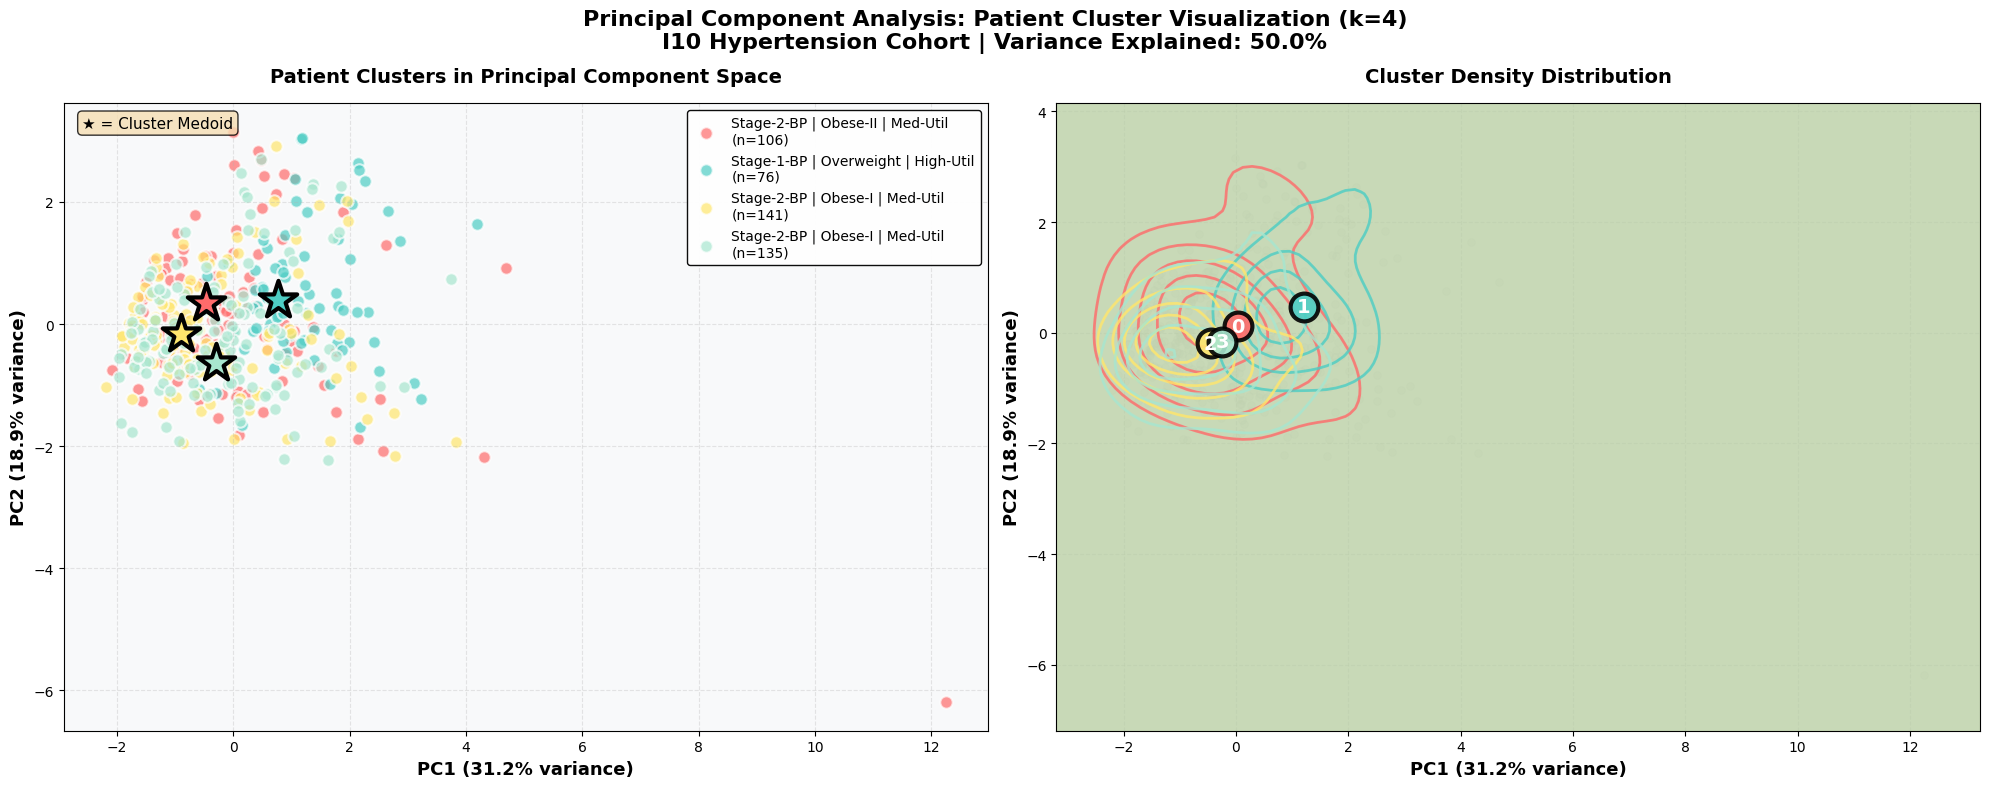


PCA Visualization Complete!

Visual Summary:
  • Left plot: Individual patients colored by cluster
  • Right plot: Cluster density distributions with contours
  • Stars (★): Cluster medoids (representative patients)
  • Colors: Distinct, vibrant palette for easy identification

Key Insights:
  • Total patients: 458
  • Number of clusters: 4
  • Variance captured by 2D projection: 50.0%



In [58]:
# Step 10d: Beautiful PCA Visualization with Distinct Colors
print(f"{'='*60}")
print("Step 10d: PCA Visualization with Beautiful Colors")
print(f"{'='*60}\n")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

# Prepare numeric data for PCA
numeric_cols = clustering_data_clean.select_dtypes(include=[np.number]).columns
pca_data = clustering_data_clean[numeric_cols].copy()

# Handle missing values for PCA (PCA doesn't accept NaN)
# Note: This is ONLY for visualization - we preserved NaN in actual clustering
n_missing_before = pca_data.isnull().sum().sum()
if n_missing_before > 0:
    print(f"⚠ Found {n_missing_before} missing values in PCA data")
    print(f"  Imputing with median for visualization only...\n")
    
    # Impute with median for each numeric column
    for col in pca_data.columns:
        if pca_data[col].isnull().sum() > 0:
            median_val = pca_data[col].median()
            n_missing = pca_data[col].isnull().sum()
            pca_data[col].fillna(median_val, inplace=True)
            print(f"  - {col}: filled {n_missing} missing values with median {median_val:.2f}")
    
    print(f"\n✓ PCA data ready (missing values imputed for visualization only)\n")
else:
    print(f"✓ No missing values in PCA data\n")

# Standardize before PCA
scaler = StandardScaler()
pca_data_scaled = scaler.fit_transform(pca_data)

# Apply PCA
pca = PCA(n_components=2, random_state=RANDOM_SEED)
pca_coords = pca.fit_transform(pca_data_scaled)

print(f"PCA Results:")
print(f"  PC1 explains: {pca.explained_variance_ratio_[0]*100:.1f}% of variance")
print(f"  PC2 explains: {pca.explained_variance_ratio_[1]*100:.1f}% of variance")
print(f"  Total variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%\n")

# Create beautiful visualization with distinct colors
fig = plt.figure(figsize=(20, 8))

# Define beautiful color palette - vibrant and distinct colors
beautiful_colors = [
    '#FF6B6B',  # Coral Red
    '#4ECDC4',  # Turquoise
    '#FFE66D',  # Yellow
    '#A8E6CF',  # Mint Green
    '#FF8B94',  # Pink
    '#C7CEEA',  # Lavender
    '#FFDAB9',  # Peach
]

# Use colors based on optimal_k
cluster_colors = beautiful_colors[:optimal_k_selected]

# Left plot: Scatter plot with beautiful colors
ax1 = plt.subplot(1, 2, 1)

# Plot each cluster with its beautiful color
for cluster_id in range(optimal_k_selected):
    mask = final_labels == cluster_id
    cluster_size = mask.sum()
    
    # Get cluster name if available
    cluster_name = f"Cluster {cluster_id}"
    if 'cluster_name' in final_profiles.columns:
        cluster_name = final_profiles.loc[cluster_id, 'cluster_name']
    
    ax1.scatter(pca_coords[mask, 0], pca_coords[mask, 1], 
               c=cluster_colors[cluster_id], 
               label=f'{cluster_name}\n(n={cluster_size})',
               alpha=0.7, s=80, edgecolors='white', linewidth=1.5)

# Add medoids as stars
medoid_coords = pca_coords[final_medoid_indices]
for i, (mx, my) in enumerate(medoid_coords):
    ax1.scatter(mx, my, c=cluster_colors[i], marker='*', s=800, 
               edgecolors='black', linewidth=3, zorder=10)

# Style the plot
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax1.set_title('Patient Clusters in Principal Component Space', 
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=10, loc='best', framealpha=0.95, edgecolor='black', fancybox=True)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#F8F9FA')

# Add annotation for medoids
ax1.text(0.02, 0.98, '★ = Cluster Medoid', 
        transform=ax1.transAxes, fontsize=11, 
        verticalalignment='top', bbox=dict(boxstyle='round', 
        facecolor='wheat', alpha=0.8))

# Right plot: Density contours with colors
ax2 = plt.subplot(1, 2, 2)

# Create a beautiful background with all points in light gray first
ax2.scatter(pca_coords[:, 0], pca_coords[:, 1], 
           c='lightgray', alpha=0.2, s=30, zorder=1)

# Overlay clusters with contours and colors
from scipy.stats import gaussian_kde

for cluster_id in range(optimal_k_selected):
    mask = final_labels == cluster_id
    cluster_points = pca_coords[mask]
    
    if len(cluster_points) > 2:  # Need at least 3 points for KDE
        # Calculate KDE
        try:
            kde = gaussian_kde(cluster_points.T)
            
            # Create grid for contour
            x_min, x_max = pca_coords[:, 0].min() - 1, pca_coords[:, 0].max() + 1
            y_min, y_max = pca_coords[:, 1].min() - 1, pca_coords[:, 1].max() + 1
            xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            positions = np.vstack([xx.ravel(), yy.ravel()])
            
            # Evaluate KDE
            density = np.reshape(kde(positions).T, xx.shape)
            
            # Plot contours with beautiful colors
            ax2.contourf(xx, yy, density, levels=5, colors=[cluster_colors[cluster_id]], 
                        alpha=0.3, zorder=2)
            ax2.contour(xx, yy, density, levels=5, colors=[cluster_colors[cluster_id]], 
                       linewidths=2, alpha=0.8, zorder=3)
        except:
            pass

# Add cluster centers with beautiful colors
for cluster_id in range(optimal_k_selected):
    mask = final_labels == cluster_id
    center_x = pca_coords[mask, 0].mean()
    center_y = pca_coords[mask, 1].mean()
    
    ax2.scatter(center_x, center_y, c=cluster_colors[cluster_id], 
               marker='o', s=400, edgecolors='black', linewidth=3, 
               zorder=10, alpha=0.9)
    
    # Add cluster label
    ax2.text(center_x, center_y, str(cluster_id), 
            fontsize=14, fontweight='bold', ha='center', va='center',
            color='white', zorder=11)

# Style the plot
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax2.set_title('Cluster Density Distribution', 
             fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_facecolor('#F8F9FA')

# Overall title
plt.suptitle(f'Principal Component Analysis: Patient Cluster Visualization (k={optimal_k_selected})\n' + 
             f'I10 Hypertension Cohort | Variance Explained: {sum(pca.explained_variance_ratio_)*100:.1f}%',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()

# Save the plot
output_path = output_dir / f"pca_visualization_beautiful_k{optimal_k_selected}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved beautiful PCA visualization: {output_path}")
plt.show()

print(f"\n{'='*60}")
print("PCA Visualization Complete!")
print(f"{'='*60}\n")
print(f"Visual Summary:")
print(f"  • Left plot: Individual patients colored by cluster")
print(f"  • Right plot: Cluster density distributions with contours")
print(f"  • Stars (★): Cluster medoids (representative patients)")
print(f"  • Colors: Distinct, vibrant palette for easy identification")
print(f"\nKey Insights:")
print(f"  • Total patients: {len(pca_coords):,}")
print(f"  • Number of clusters: {optimal_k_selected}")
print(f"  • Variance captured by 2D projection: {sum(pca.explained_variance_ratio_)*100:.1f}%")
print(f"\n{'='*60}")


Creating evaluation metrics dashboard...



/var/folders/20/f9p3qbtx0dgbym5c0l8wdnr00000gn/T/ipykernel_727/885107239.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✓ Saved: outputs/visualizations/i10_clustering/evaluation_metrics_dashboard.png


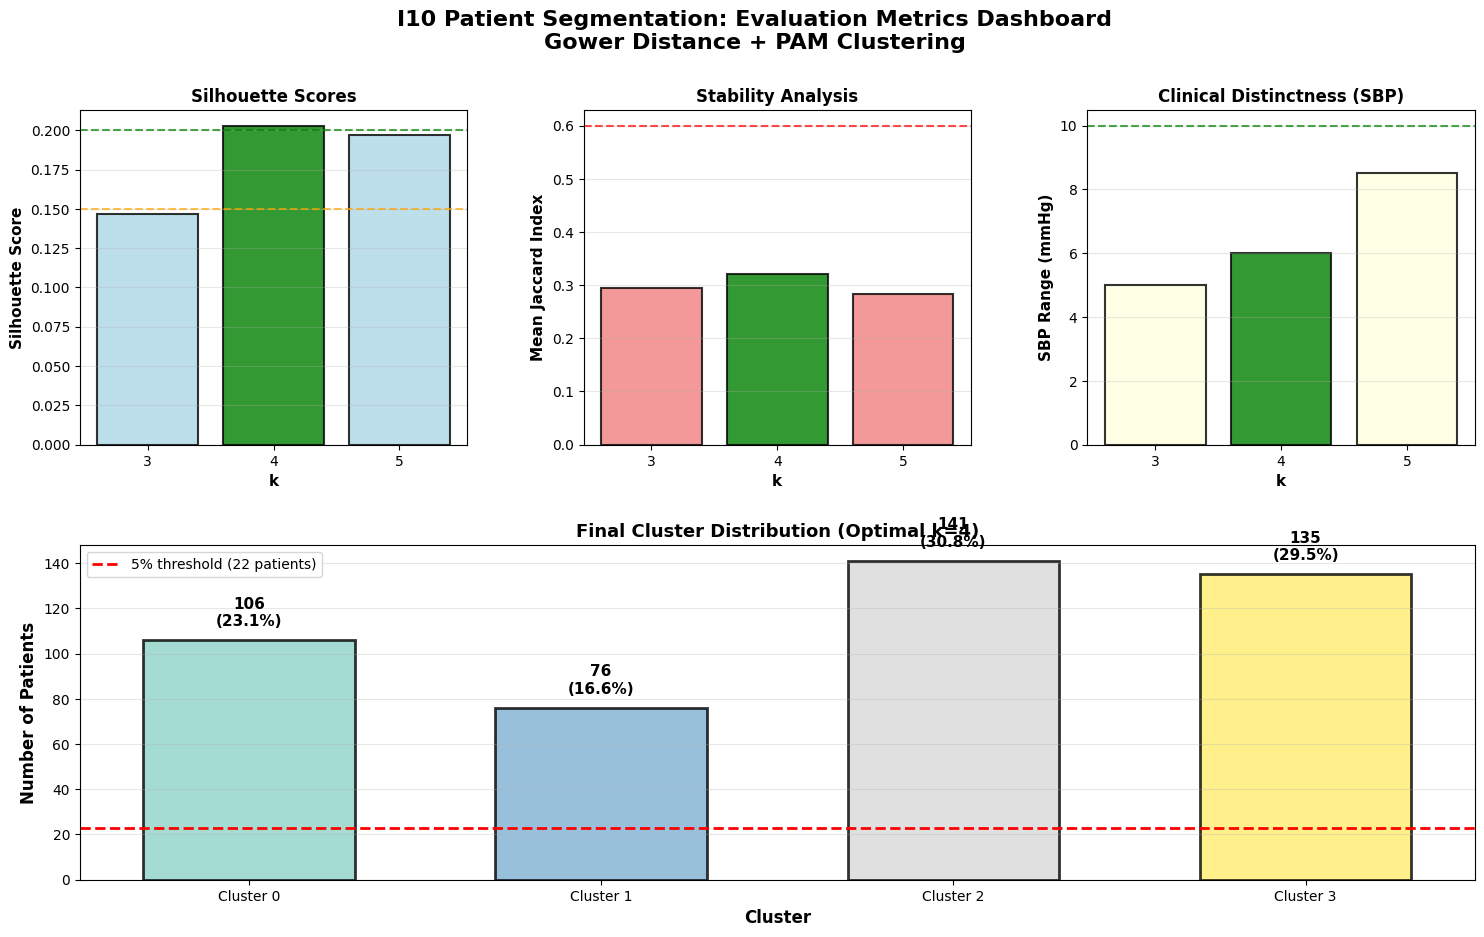

In [59]:
# Step 10e: Final summary visualization - Evaluation metrics dashboard
print("Creating evaluation metrics dashboard...\n")

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Silhouette scores across k
ax1 = fig.add_subplot(gs[0, 0])
silhouette_scores = [clustering_results[k]['silhouette'] for k in k_values]
colors_sil = ['green' if k == optimal_k_selected else 'lightblue' for k in k_values]
ax1.bar(k_values, silhouette_scores, color=colors_sil, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.axhline(y=0.15, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.axhline(y=0.20, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('k', fontsize=11, fontweight='bold')
ax1.set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
ax1.set_title('Silhouette Scores', fontsize=12, fontweight='bold')
ax1.set_xticks(k_values)
ax1.grid(True, alpha=0.3, axis='y')

# 2. Stability (Jaccard) across k
ax2 = fig.add_subplot(gs[0, 1])
stability_scores = [clustering_results[k]['stability_mean'] for k in k_values]
colors_stab = ['green' if k == optimal_k_selected else 'lightcoral' for k in k_values]
ax2.bar(k_values, stability_scores, color=colors_stab, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=0.60, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_xlabel('k', fontsize=11, fontweight='bold')
ax2.set_ylabel('Mean Jaccard Index', fontsize=11, fontweight='bold')
ax2.set_title('Stability Analysis', fontsize=12, fontweight='bold')
ax2.set_xticks(k_values)
ax2.grid(True, alpha=0.3, axis='y')

# 3. SBP range by k
ax3 = fig.add_subplot(gs[0, 2])
sbp_ranges = []
for k in k_values:
    profiles = clinical_profiles[k]
    sbp_medians = profiles['sbp_latest_median'].values
    sbp_range = sbp_medians.max() - sbp_medians.min()
    sbp_ranges.append(sbp_range)
colors_sbp = ['green' if k == optimal_k_selected else 'lightyellow' for k in k_values]
ax3.bar(k_values, sbp_ranges, color=colors_sbp, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.axhline(y=10, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('k', fontsize=11, fontweight='bold')
ax3.set_ylabel('SBP Range (mmHg)', fontsize=11, fontweight='bold')
ax3.set_title('Clinical Distinctness (SBP)', fontsize=12, fontweight='bold')
ax3.set_xticks(k_values)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Cluster sizes for optimal k
ax4 = fig.add_subplot(gs[1, :])
cluster_sizes_opt = [clustering_results[optimal_k_selected]['cluster_sizes'][i] 
                     for i in range(optimal_k_selected)]
cluster_pcts_opt = [(size / len(final_results_df)) * 100 for size in cluster_sizes_opt]

x_pos = np.arange(optimal_k_selected)
colors_size = plt.cm.Set3(np.linspace(0, 1, optimal_k_selected))
bars = ax4.bar(x_pos, cluster_sizes_opt, color=colors_size, alpha=0.8, 
              edgecolor='black', linewidth=2, width=0.6)

# Add labels
for i, (bar, size, pct) in enumerate(zip(bars, cluster_sizes_opt, cluster_pcts_opt)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{size}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add threshold line
threshold_line = 0.05 * len(final_results_df)
ax4.axhline(y=threshold_line, color='red', linestyle='--', linewidth=2, 
           label=f'5% threshold ({int(threshold_line)} patients)')

ax4.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Patients', fontsize=12, fontweight='bold')
ax4.set_title(f'Final Cluster Distribution (Optimal k={optimal_k_selected})', 
             fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'Cluster {i}' for i in range(optimal_k_selected)])
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('I10 Patient Segmentation: Evaluation Metrics Dashboard\nGower Distance + PAM Clustering',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

output_path = output_dir / "evaluation_metrics_dashboard.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved: {output_path}")
plt.show()

print(f"\n{'='*60}")


In [60]:
# Final summary
print(f"{'='*60}")
print("CLUSTERING COMPLETE!")
print(f"{'='*60}\n")

print(f"Summary of Results:")
print(f"  Optimal k: {optimal_k_selected}")
print(f"  Recommendation level: {recommendation_level}")
print(f"  Total patients: {len(final_results_df):,}")
print(f"  Silhouette score: {clustering_results[optimal_k_selected]['silhouette']:.4f}")
print(f"  Stability (Jaccard): {clustering_results[optimal_k_selected]['stability_mean']:.4f}")
print()

print(f"Output files saved:")
print(f"  Cluster assignments: outputs/data/i10_cluster_assignments.csv")
print(f"  Cluster profiles: outputs/data/i10_cluster_profiles.csv")
print(f"  Medoid information: outputs/data/i10_cluster_medoids.csv")
print(f"  Evaluation metrics: outputs/data/i10_clustering_evaluation.csv")
print()

print(f"Visualizations saved to: outputs/visualizations/i10_clustering/")
viz_files = list(output_dir.glob("*.png"))
print(f"  Total visualizations: {len(viz_files)}")
for viz_file in sorted(viz_files):
    print(f"    - {viz_file.name}")

print(f"\n{'='*60}")
print("Next steps:")
print("  1. Review cluster profiles and clinical interpretability")
print("  2. Validate clusters with domain experts")
print("  3. Use cluster assignments for targeted interventions")
print("  4. Monitor cluster characteristics over time")
print(f"{'='*60}")


CLUSTERING COMPLETE!

Summary of Results:
  Optimal k: 4
  Recommendation level: COMPROMISE
  Total patients: 458
  Silhouette score: 0.2030
  Stability (Jaccard): 0.3211

Output files saved:
  Cluster assignments: outputs/data/i10_cluster_assignments.csv
  Cluster profiles: outputs/data/i10_cluster_profiles.csv
  Medoid information: outputs/data/i10_cluster_medoids.csv
  Evaluation metrics: outputs/data/i10_clustering_evaluation.csv

Visualizations saved to: outputs/visualizations/i10_clustering/
  Total visualizations: 20
    - clinical_boxplots_k3.png
    - clinical_boxplots_k4.png
    - clinical_boxplots_k5.png
    - clinical_boxplots_k6.png
    - clinical_boxplots_k7.png
    - clinical_profile_heatmap_k3.png
    - clinical_profile_heatmap_k4.png
    - evaluation_metrics_dashboard.png
    - final_cluster_sizes_k3.png
    - final_cluster_sizes_k4.png
    - gower_distance_distribution.png
    - gower_distance_heatmap_sample.png
    - medoid_profiles_k3.png
    - medoid_profiles_k4.pn